# Data Preprocessing

# 1. Import All Necessary Libraries and Create File Paths

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from osgeo import gdal, gdal_array
import sys
import cv2

In [66]:
import os

# folder path or file path constants that will be used in this project

# Root Directory (between 'F:' or 'D:'' depends on the external drive)
ROOT = "D:"

# Folder inside D:\\wildfire-sumatera-dataset
WILDFIRE_SUMATERA_DATASET_FOLDER_PATH = f"{ROOT}\\wildfire-sumatera-dataset"


# Folders and metadatas inside D:\\wildfire-sumatera-dataset
WILDFIRE_SUMATERA_GEOTIFF_FOLDER_PATH        = f"{WILDFIRE_SUMATERA_DATASET_FOLDER_PATH}\\wildfire-sumatera-geotiff"
WILDFIRE_SUMATERA_JPEG_FOLDER_PATH           = f"{WILDFIRE_SUMATERA_DATASET_FOLDER_PATH}\\wildfire-sumatera-jpeg"

# Files (.csv) and metadatas inside D:\\wildfire-sumatera-dataset
METADATA_LANDSAT_8_FILE_PATH  = f"{WILDFIRE_SUMATERA_DATASET_FOLDER_PATH}\\metadata_landsat_8.csv"
METADATA_SENTINEL_2_FILE_PATH = f"{WILDFIRE_SUMATERA_DATASET_FOLDER_PATH}\\metadata_sentinel_2.csv"



# Folders inside D:\\wildfire-sumatera-dataset\\wildfire-sumatera-geotiff
SENTINEL_2_GEOTIFF_FOLDER_PATH = f"{WILDFIRE_SUMATERA_GEOTIFF_FOLDER_PATH}\\sentinel-2"
LANDSAT_8_GEOTIFF_FOLDER_PATH  = f"{WILDFIRE_SUMATERA_GEOTIFF_FOLDER_PATH}\\landsat-8"


# Folders inside D:\\wildfire-sumatera-dataset\\wildfire-sumatera-jpeg
SENTINEL_2_JPEG_FOLDER_PATH = f"{WILDFIRE_SUMATERA_JPEG_FOLDER_PATH}\\sentinel-2"
LANDSAT_8_JPEG_FOLDER_PATH  = f"{WILDFIRE_SUMATERA_JPEG_FOLDER_PATH}\\landsat-8"



# Folders inside D:\\wildfire-sumatera-dataset\\wildfire-sumatera-geotiff\\landsat-8
LANDSAT_8_PREFIRE_GEOTIFF_FOLDER_PATH  = f"{LANDSAT_8_GEOTIFF_FOLDER_PATH}\\prefire"
LANDSAT_8_POSTFIRE_GEOTIFF_FOLDER_PATH = f"{LANDSAT_8_GEOTIFF_FOLDER_PATH}\\postfire"

# Folders inside D:\\wildfire-sumatera-dataset\\wildfire-sumatera-geotiff\\sentinel-2
SENTINEL_2_PREFIRE_GEOTIFF_FOLDER_PATH  = f"{SENTINEL_2_GEOTIFF_FOLDER_PATH}\\prefire"
SENTINEL_2_POSTFIRE_GEOTIFF_FOLDER_PATH = f"{SENTINEL_2_GEOTIFF_FOLDER_PATH}\\postfire"


dirs = [
    WILDFIRE_SUMATERA_DATASET_FOLDER_PATH,
    WILDFIRE_SUMATERA_GEOTIFF_FOLDER_PATH, 
    WILDFIRE_SUMATERA_JPEG_FOLDER_PATH,
    
    SENTINEL_2_GEOTIFF_FOLDER_PATH, 
    LANDSAT_8_GEOTIFF_FOLDER_PATH,
    SENTINEL_2_JPEG_FOLDER_PATH,
    LANDSAT_8_JPEG_FOLDER_PATH,
    
    LANDSAT_8_PREFIRE_GEOTIFF_FOLDER_PATH,
    LANDSAT_8_POSTFIRE_GEOTIFF_FOLDER_PATH,
    SENTINEL_2_PREFIRE_GEOTIFF_FOLDER_PATH,
    SENTINEL_2_POSTFIRE_GEOTIFF_FOLDER_PATH,
]

for dir_ in dirs:
    if not os.path.exists(dir_):
        os.mkdir(dir_)
        print(f"{dir_} has been created")
    else:
        print(f"{dir_} already exist")

D:\wildfire-sumatera-dataset already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2 already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8 already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2 already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8 already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\prefire already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\prefire already exist
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire already exist


# 2. Access The Dataset
The dataset name is **data-total.csv** which contains all the necessary information about dates and location coordinates of a wildfire events in Indonesia.

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

wf_data  = pd.read_csv("data-total.csv")
wf_data.columns

# rename columns
wf_data.rename(
    columns={
        'Lat': 'lat', 
        'Long': 'long', 
        'Satellite': 'satellite', 
        'Time_UTC': 'time_utc', 
        'Date': 'date', 
        'Source': 'source', 
        'PROVINSI': 'provinsi',
        'KAB_KOTA': 'kab_kota'
        }, 
    inplace=True,
    )

# adding '-' to date column values
wf_data.date = pd.to_datetime(wf_data.date, format="%Y%m%d")
wf_data.date = wf_data.date.astype('string')

# All provinces in sumatera
sumatera_provinces = [
    'SUMATERA UTARA',
    'JAMBI',
    'RIAU',
    'SUMATERA BARAT',
    'SUMATERA SELATAN',
    'BENGKULU',
    'LAMPUNG',
    'ACEH',
    ]

# create filter so that only events in sumatera will be returned.
sumatera_filter = wf_data['provinsi'].apply(lambda x: x in sumatera_provinces) 
sumatera_only = wf_data.loc[sumatera_filter]

display(sumatera_only.info())
display(sumatera_only.provinsi.unique())
display(sumatera_only.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7839 entries, 1 to 39670
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        7839 non-null   float64
 1   long       7839 non-null   float64
 2   satellite  7839 non-null   object 
 3   time_utc   7839 non-null   object 
 4   date       7839 non-null   string 
 5   source     7839 non-null   object 
 6   provinsi   7839 non-null   object 
 7   kab_kota   7839 non-null   object 
 8   kec2006    7830 non-null   object 
 9   desaa2006  7830 non-null   object 
 10  nama_kaw   930 non-null    object 
dtypes: float64(2), object(8), string(1)
memory usage: 734.9+ KB


None

array(['LAMPUNG', 'RIAU', 'SUMATERA UTARA', 'SUMATERA BARAT',
       'SUMATERA SELATAN', 'ACEH', 'JAMBI', 'BENGKULU'], dtype=object)

lat     long satellite     time_utc        date source        provinsi  \
1 -5.06259  105.101   LPN-NPP  06:11:04 AM  2016-08-24  LAPAN         LAMPUNG   
4  1.18991  100.672   LPN-NPP  06:29:59 AM  2016-08-23  LAPAN            RIAU   
5  2.31418  100.288   LPN-NPP  06:29:59 AM  2016-08-23  LAPAN  SUMATERA UTARA   
6  1.41833  100.752   LPN-NPP  06:29:59 AM  2016-08-23  LAPAN            RIAU   
8  1.38958  100.673   LPN-NPP  06:36:36 AM  2016-09-13  LAPAN            RIAU   

         kab_kota              kec2006              desaa2006 nama_kaw  
1  LAMPUNG TENGAH            ANAK TUHA              BUMI JAYA      NaN  
4      ROKAN HULU  KECAMATAN KAPENUHAN  UPT SP IV KOTO TENGAH      NaN  
5     LABUHANBATU         PANAI TENGAH           SELAT BETING      NaN  
6     ROKAN HILIR      KECAMATAN PUJUD          SIARANG ARANG      NaN  
8     ROKAN HILIR      KECAMATAN PUJUD           TELUK NAYANG      NaN

In [4]:
# sort the data in based on 'date' column in ascending order
sumatera_only = sumatera_only.sort_values(
    by=['date'], 
    ascending=True,
    ignore_index=True,
)

sumatera_only.head()

lat      long satellite     time_utc        date source provinsi  \
0  1.64968  100.8920   LPN-NPP  06:24:35 AM  2016-04-12  LAPAN     RIAU   
1  1.64853  100.8840   LPN-NPP  06:24:35 AM  2016-04-12  LAPAN     RIAU   
2  1.58003  100.8550   LPN-NPP  06:24:35 AM  2016-04-12  LAPAN     RIAU   
3  4.27236   97.7478   LPN-NPP  06:24:35 AM  2016-04-12  LAPAN     ACEH   
4  1.65664  100.8910   LPN-NPP  06:24:35 AM  2016-04-12  LAPAN     RIAU   

       kab_kota                  kec2006       desaa2006 nama_kaw  
0   ROKAN HILIR  KECAMATAN BANGKO PUSAKO  SUNGAI MENASIB      NaN  
1   ROKAN HILIR  KECAMATAN BANGKO PUSAKO  SUNGAI MENASIB      NaN  
2   ROKAN HILIR    KECAMATAN TANAH PUTIH  BALAM SEMPURNA      NaN  
3  ACEH TAMIANG             TAMIANG HULU   BATU BEDULANG      NaN  
4   ROKAN HILIR  KECAMATAN BANGKO PUSAKO  SUNGAI MENASIB      NaN

# 3. Create All Functions for the Project and Constants

In [5]:
def get_img_as_array(filepath, dictionary):
    """
    :param filepath: location of the satellite bands
    :param dictionary: information about the image bands
    :return: dictionary containing name of the satellite bands as key and array of pixels as value  
    """
    os.chdir(filepath)
    print(filepath)
    band_imgs = {}
    for key, val in dictionary.items():
        # open the .tiff file
        if os.path.exists(filepath):
            tiff_file = gdal.Open(key)
            bands = key.split('_')
            for i, band in enumerate(bands):
                band_imgs[band] = tiff_file.GetRasterBand(i+1).ReadAsArray()
    
    return band_imgs

In [6]:
def convert_to_jpeg(bands=[], file_path=""):
    """
    :param bands: array of satellite image bands
    :param filepath: location of the image being stored
    :return: return result of the conversion (True which is 'success' or False which is 'failed') 
    """
    if not bands:
        print("bands cannot be empty")
        return 
    
    if not file_path:
        print("filename cannot be empty")
        return
    img = cv2.merge(bands)
    cv2.imwrite(file_path, img*256)
    return True

In [7]:
def get_class(data):
    """
    :param data: array of values whether mean or median of Delta Normalized Burn Ratio (dNBR)
    :return: an array filled with labels or classes based on their dNBR mean or median.
    """
    burn_severity_class = []
    for value in data:
        if value <= 0.22:
            burn_severity_class.append(0)
        elif value <= 0.4:
            burn_severity_class.append(1)
        elif value > 0.4:
            burn_severity_class.append(2)
        else:
            burn_severity_class.append(-1)
            
    return burn_severity_class

In [15]:
def get_mean_and_median_dnbr(folder_paths_geotiff, dictionary):
    """
    :param folder_paths_geotiff: an array full of folder paths which contain satellite image in GeoTIFF format
    :param dictionary: a dictionary contain filename of bands as key and the amount of bands inside the GeoTIFF file
    :return: return a tuple of mean of dNBR and median of dNBR
    """
    mean_dnbr_arr=[]
    median_dnbr_arr=[]
    
    for folder in folder_paths_geotiff:
        img_band = get_img_as_array(ROOT+folder, dictionary)

        # find mean of dnbr only value greater than or equal to 0.05
        try:
            temp = img_band['dnbr']
            # Change the data that has no value to zero
            temp = np.where(temp==None, 0, temp)
            temp = np.where(temp>=0.05, temp, np.nan)
        except:
            print(sys.exc_info()[0], "occurred.")
            image_condition.append(0)
            
        mean_dnbr_arr.append(np.nanmean(temp))
        median_dnbr_arr.append(np.nanmedian(temp))
        
    return (mean_dnbr_arr, median_dnbr_arr)

In [16]:
LANDSAT_POSTFIRE_DICT = {
    'dnbr_b7': 2,
    'b5_b4': 2,
    'b3_b2': 2
}

SENTINEL_POSTFIRE_DICT = {
    'dnbr_b12': 2,
    'b8_b4': 2,
    'b3_b2': 2
}

# 4. Create Dataframe
## 4.1 Landsat
All columns inside this dataframe are:
1. folder_paths_geotiff = use to store all folder paths for geotiff
1. folder_paths_jpeg = use to store all file paths for jpeg
2. class_by_mean = use to determine the label of the image based on mean_dnbr
2. class_by_median = use to determine the label of the image on median_dnbr
3. mean_dnbr = stores mean of pixels in delta normalized burned ratio. 
4. median_dnbr = stores median of pixels in delta normalized burned ratio.

In [17]:
# get list of folder paths
landsat_dictionary = {}
landsat_dictionary['folder_paths_geotiff'] = os.listdir(LANDSAT_8_POSTFIRE_GEOTIFF_FOLDER_PATH)

# sort using key = int to convert data to int first before sorting
landsat_dictionary['folder_paths_geotiff'].sort(key=int)

# add a folder path of its parent 
landsat_dictionary['folder_paths_geotiff'] = [
    "\\" + "\\".join(LANDSAT_8_POSTFIRE_GEOTIFF_FOLDER_PATH.split("\\")[1:]) + "\\" + folder_name 
    for folder_name in landsat_dictionary['folder_paths_geotiff']]

## 4.1.1 Calculate Mean and Median dNBR
Calculate the mean and median of Delta Normalized Burned Ration of each image

In [19]:
landsat_dictionary['mean_dnbr'], landsat_dictionary['median_dnbr'] =  get_mean_and_median_dnbr(
    landsat_dictionary['folder_paths_geotiff'], 
    LANDSAT_POSTFIRE_DICT,
)

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\0
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\8
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\9
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\10
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\11
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\12
D:\wildfi

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\108
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\109
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\110
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\111
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\112
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\113
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\114
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\115
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\116
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\117
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\118
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\119
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\214
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\215
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\216
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\217
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\218
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\219
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\220
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\221
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\222
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\223
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\224
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\225
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\320
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\321
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\322
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\323
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\324
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\325
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\326
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\327
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\328
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\329
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\330
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\331
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\426
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\427
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\428
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\429
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\430
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\431
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\432
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\433
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\434
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\435
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\436
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\437
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\533
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\534
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\535
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\536
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\537
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\538
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\539
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\540
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\541
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\542
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\543
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\544
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\640
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\641
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\642
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\643
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\644
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\645
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\646
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\647
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\648
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\649
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\650
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\651
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\746
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\747
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\748
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\749
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\750
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\751
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\752
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\753
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\754
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\755
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\756
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\757
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\852
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\853
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\854
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\855
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\856
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\857
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\858
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\859
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\860
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\861
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\862
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\863
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\958
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\959
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\960
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\961
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\962
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\963
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\964
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\965
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\966
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\967
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\968
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\969
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1064
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1065
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1066
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1067
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1068
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1069
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1070
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1071
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1072
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1073
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1074
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1075
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1168
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1169
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1170
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1171
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1172
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1173
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1174
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1175
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1176
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1177
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1178
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1179
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1272
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1273
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1274
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1275
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1276
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1277
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1278
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1279
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1280
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1281
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1282
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1283
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1376
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1377
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1378
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1379
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1380
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1381
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1382
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1383
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1384
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1385
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1386
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1387
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1480
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1481
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1482
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1483
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1484
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1485
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1486
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1487
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1488
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1489
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1490
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1491
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1585
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1586
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1587
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1588
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1589
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1590
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1591
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1592
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1593
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1594
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1595
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1596
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1690
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1691
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1692
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1693
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1694
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1695
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1696
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1697
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1698
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1699
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1700
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1701
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1795
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1796
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1797
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1798
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1799
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1800
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1801
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1802
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1803
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1804
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1805
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1806
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1900
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1901
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1902
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1903
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1904
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1905
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1906
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1907
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1908
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1909
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1910
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1911
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2004
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2005
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2006
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2007
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2008
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2009
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2010
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2011
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2012
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2013
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2014
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2015
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2108
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2109
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2110
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2111
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2112
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2113
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2114
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2115
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2116
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2117
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2118
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2119
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2212
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2213
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2214
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2215
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2216
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2217
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2218
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2219
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2220
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2221
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2222
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2223
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2317
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2318
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2319
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2320
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2321
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2322
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2323
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2324
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2325
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2326
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2327
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2328
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2421
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2422
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2423
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2424
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2425
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2426
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2427
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2428
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2429
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2430
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2431
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2432
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2525
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2526
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2527
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2528
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2529
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2530
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2531
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2532
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2533
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2534
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2535
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2536
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2631
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2632
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2633
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2634
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2635
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2636
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2637
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2638
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2639
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2640
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2641
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2642
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2736
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2737
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2738
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2739
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2740
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2741
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2742
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2743
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2744
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2745
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2746
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2747
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2840
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2841
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2842
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2843
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2844
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2845
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2846
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2847
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2848
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2849
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2850
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2851
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2944
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2945
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2946
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2947
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2948
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2949
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2950
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2951
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2952
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2953
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2954
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2955
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3049
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3050
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3051
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3052
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3053
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3054
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3055
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3056
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3057
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3058
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3059
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3060
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3154
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3155
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3156
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3157
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3158
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3159
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3160
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3161
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3162
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3163
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3164
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3165
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3258
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3259
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3260
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3261
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3262
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3263
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3264
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3265
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3266
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3267
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3268
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3269
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3362
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3363
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3364
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3365
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3366
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3367
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3368
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3369
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3370
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3371
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3372
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3373
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3467
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3468
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3469
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3470
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3471
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3472
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3473
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3474
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3475
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3476
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3477
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3478
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3571
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3572
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3573
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3574
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3575
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3576
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3577
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3578
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3579
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3580
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3581
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3582
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3675
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3676
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3677
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3678
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3679
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3680
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3681
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3682
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3683
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3684
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3685
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3686
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3779
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3780
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3781
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3782
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3783
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3784
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3785
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3786
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3787
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3788
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3789
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3790
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3883
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3884
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3885
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3886
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3887
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3888
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3889
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3890
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3891
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3892
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3893
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3894
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3987
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3988
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3989
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3990
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3991
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3992
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3993
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3994
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3995
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3996
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3997
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3998
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4091
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4092
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4093
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4094
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4095
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4096
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4097
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4098
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4099
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4100
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4101
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4102
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4195
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4196
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4197
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4198
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4199
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4200
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4201
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4202
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4203
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4204
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4205
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4206
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4299
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4300
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4301
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4302
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4303
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4304
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4305
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4306
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4307
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4308
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4309
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4310
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4403
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4404
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4405
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4406
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4407
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4408
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4409
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4410
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4411
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4412
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4413
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4414
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4507
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4508
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4509
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4510
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4511
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4512
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4513
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4514
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4515
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4516
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4517
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4518
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4611
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4612
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4613
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4614
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4615
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4616
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4617
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4618
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4619
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4620
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4621
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4622
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4715
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4716
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4717
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4718
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4719
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4720
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4721
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4722
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4723
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4724
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4725
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4726
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4820
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4821
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4822
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4823
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4824
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4825
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4826
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4827
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4828
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4829
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4830
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4831
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4924
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4925
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4926
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4927
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4928
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4929
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4930
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4931
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4932
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4933
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4934
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4935
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5029
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5030
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5031
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5032
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5033
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5034
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5035
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5036
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5037
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5038
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5039
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5040
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5133
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5134
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5135
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5136
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5137
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5138
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5139
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5140
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5141
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5142
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5143
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5144
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5237
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5238
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5239
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5240
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5241
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5242
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5243
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5244
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5245
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5246
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5247
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5248
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5342
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5343
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5344
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5345
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5346
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5347
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5348
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5349
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5350
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5351
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5352
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5353
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5446
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5447
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5448
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5449
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5450
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5451
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5452
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5453
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5454
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5455
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5456
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5457
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5550
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5551
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5552
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5553
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5554
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5555
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5556
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5557
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5558
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5559
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5560
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5561
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5655
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5656
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5657
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5658
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5659
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5660
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5661
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5662
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5663
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5664
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5665
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5666
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5760
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5761
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5762
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5763
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5764
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5765
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5766
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5767
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5768
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5769
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5770
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5771
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5865
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5866
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5867
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5868
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5869
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5870
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5871
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5872
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5873
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5874
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5875
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5876
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5969
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5970
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5971
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5972
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5973
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5974
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5975
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5976
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5977
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5978
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5979
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5980
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6073
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6074
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6075
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6076
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6077
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6078
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6079
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6080
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6081
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6082
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6083
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6084
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6178
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6179
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6180
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6181
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6182
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6183
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6184
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6185
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6186
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6187
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6188
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6189
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6282
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6283
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6284
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6285
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6286
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6287
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6288
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6289
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6290
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6291
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6292
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6293
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6386
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6387
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6388
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6389
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6390
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6391
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6392
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6393
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6394
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6395
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6396
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6397
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6491
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6492
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6493
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6494
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6495
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6496
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6497
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6498
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6499
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6500
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6501
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6502
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6596
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6597
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6598
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6599
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6600
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6601
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6602
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6603
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6604
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6605
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6606
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6607
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6700
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6701
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6702
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6703
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6704
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6705
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6706
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6707
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6708
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6709
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6710
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6711
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6804
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6805
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6806
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6807
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6808
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6809
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6810
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6811
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6812
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6813
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6814
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6815
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6908
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6909
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6910
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6911
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6912
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6913
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6914
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6915
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6916
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6917
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6918
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6919
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7012
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7013
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7014
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7015
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7016
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7017
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7018
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7019
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7020
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7021
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7022
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7023
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7116
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7117
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7118
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7119
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7120
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7121
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7122
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7123
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7124
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7125
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7126
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7127
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7220
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7221
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7222
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7223
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7224
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7225
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7226
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7227
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7228
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7229
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7230
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7231
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7324
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7325
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7326
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7327
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7328
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7329
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7330
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7331
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7332
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7333
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7334
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7335
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7428
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7429
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7430
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7431
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7432
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7433
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7434
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7435
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7436
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7437
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7438
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7439
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7532
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7533
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7534
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7535
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7536
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7537
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7538
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7539
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7540
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7541
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7542
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7543
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7637
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7638
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7639
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7640
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7641
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7642
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7643
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7644
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7645
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7646
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7647
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7648
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7741
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7742
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7743
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7744
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7745
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7746
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7747
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7748
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7749
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7750
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7751
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7752
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

## 4.1.2 Save Landsat Dictionary as CSV File

In [20]:
# convert to pandas DataFrame and export as .csv file
landsat_df = pd.DataFrame(landsat_dictionary)
landsat_df.to_csv(WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_landsat_8_new.csv", index=False)

## 4.1.3 Open CSV File

In [45]:
landsat_df = pd.read_csv(os.path.join(WILDFIRE_SUMATERA_DATASET_FOLDER_PATH, "metadata_landsat_8_new.csv"))

## 4.1.4 Classify Images Using Mean and Median dNBR
<img src="./images/dNBR_classification_and_class_boundaries.jpg" alt="dNBR_classification_and_class_boundaries">

1. Low severity = 0
2. Moderate severity = 1
3. High severity = 2

In [46]:
landsat_df["class_by_mean"] = get_class(landsat_df["mean_dnbr"])
landsat_df["class_by_median"] = get_class(landsat_df["median_dnbr"])

In [47]:
landsat_df.head()

folder_paths_geotiff  mean_dnbr  median_dnbr  \
0  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.118657     0.092437   
1  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.118892     0.092641   
2  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124600     0.095925   
3  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.099432     0.074912   
4  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.118605     0.092377   

   class_by_mean  class_by_median  
0              0                0  
1              0                0  
2              0                0  
3              0                0  
4              0                0

## 4.1.5 Countplot of Landsat-8 Burn Severity Class by Mean dNBR

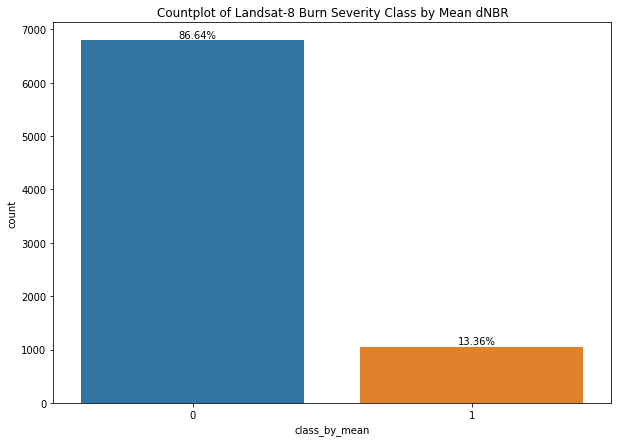

In [48]:
plt.figure(figsize=(10,7))
plt.title("Countplot of Landsat-8 Burn Severity Class by Mean dNBR")
ax = sns.countplot(x='class_by_mean', data=landsat_df)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(landsat_df)*100), (p.get_x()+0.35, p.get_height()+50))
plt.show()

## 4.1.6 Countplot of Landsat-8 Burn Severity Class by Median dNBR

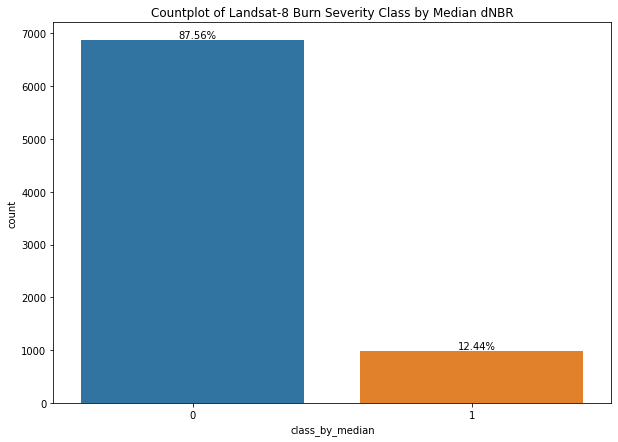

In [49]:
plt.figure(figsize=(10,7))
plt.title("Countplot of Landsat-8 Burn Severity Class by Median dNBR")
ax = sns.countplot(x='class_by_median', data=landsat_df)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(landsat_df)*100), (p.get_x()+0.35, p.get_height()+50))
plt.show()

## 4.1.7 Convert GeoTIFF File to JPEG File
The conversion involve 2 steps which convert the GeoTIFF file into array of bands (fill with pixels) before being stacked and convert it into JPEG file using **opencv**.


In [67]:
image_condition = []
file_paths_jpeg = []
ext = ".jpeg"

# Looping through the GeoTIFF file paths from the landsat_metadata
for folder in landsat_df['folder_paths_geotiff']:
    # create a new file name with its extension
    file_path = LANDSAT_8_JPEG_FOLDER_PATH + "\\" + folder.split('\\')[-1] + ext
    file_paths_jpeg.append("\\"+"\\".join(file_path.split("\\")[1:]))
    print(file_path)
    # if the .jpeg file doesn't exist create the file 
    if not os.path.exists(file_path):
        try:
            # get image bands as an array 
            landsat_postfire_img_band = get_img_as_array(folder, LANDSAT_POSTFIRE_DICT)
            # convert to .jpeg
            result = convert_to_jpeg(
                bands = [
                    landsat_postfire_img_band['b2'],
                    landsat_postfire_img_band['b3'],                    
                    landsat_postfire_img_band['dnbr'],                    
                ],
                file_path = file_path,
                )
            # if the result is a success append 1 to the image condition
            if result:
                image_condition.append(1)
                
        # if the process was unsuccessful just append the image condition to 0 so that it won't be used
        except:
            print(sys.exc_info()[0], "occurred.")
            image_condition.append(0)
            
    # if the .jpeg file already exists just append the image condition to one
    else:
        image_condition.append(1)
        print("{} already exist".format(file_path))

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\0.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\0
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\58.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\58
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\59.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\59
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\60.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\60
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\61.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\61
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\62.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\62
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\63.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\63
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\64.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\116.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\116
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\117.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\117
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\118.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\118
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\119.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\119
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\120.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\120
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\121.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\121
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\122.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\172.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\172
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\173.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\173
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\174.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\174
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\175.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\175
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\176.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\176
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\177.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\177
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\178.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\228.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\228
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\229.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\229
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\230.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\230
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\231.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\231
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\232.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\232
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\233.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\233
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\234.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\284.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\284
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\285.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\285
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\286.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\286
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\287.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\287
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\288.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\288
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\289.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\289
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\290.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\340.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\340
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\341.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\341
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\342.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\342
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\343.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\343
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\344.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\344
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\345.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\345
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\346.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\396.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\396
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\397.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\397
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\398.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\398
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\399.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\399
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\400.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\400
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\401.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\401
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\402.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\452.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\452
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\453.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\453
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\454.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\454
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\455.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\455
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\456.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\456
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\457.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\457
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\458.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\508.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\508
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\509.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\509
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\510.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\510
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\511.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\511
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\512.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\512
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\513.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\513
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\514.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\564.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\564
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\565.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\565
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\566.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\566
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\567.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\567
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\568.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\568
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\569.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\569
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\570.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\620.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\620
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\621.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\621
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\622.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\622
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\623.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\623
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\624.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\624
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\625.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\625
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\626.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\676.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\676
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\677.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\677
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\678.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\678
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\679.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\679
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\680.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\680
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\681.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\681
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\682.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\732.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\732
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\733.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\733
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\734.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\734
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\735.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\735
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\736.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\736
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\737.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\737
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\738.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\788.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\788
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\789.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\789
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\790.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\790
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\791.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\791
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\792.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\792
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\793.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\793
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\794.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\844.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\844
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\845.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\845
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\846.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\846
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\847.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\847
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\848.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\848
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\849.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\849
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\850.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\900.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\900
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\901.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\901
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\902.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\902
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\903.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\903
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\904.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\904
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\905.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\905
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\906.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\956.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\956
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\957.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\957
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\958.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\958
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\959.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\959
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\960.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\960
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\961.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\961
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\962.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1012.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1012
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1013.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1013
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1014.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1014
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1015.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1015
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1016.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1016
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1017.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1017
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1018.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1068.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1068
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1069.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1069
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1070.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1070
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1071.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1071
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1072.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1072
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1073.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1073
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1074.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1124.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1124
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1125.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1125
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1126.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1126
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1127.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1127
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1128.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1128
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1129.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1129
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1130.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1180.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1180
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1181.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1181
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1182.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1182
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1183.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1183
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1184.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1184
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1185.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1185
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1186.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1236.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1236
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1237.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1237
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1238.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1238
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1239.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1239
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1240.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1240
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1241.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1241
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1242.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1292.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1292
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1293.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1293
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1294.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1294
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1295.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1295
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1296.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1296
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1297.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1297
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1298.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1348.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1348
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1349.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1349
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1350.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1350
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1351.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1351
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1352.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1352
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1353.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1353
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1354.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1404.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1404
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1405.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1405
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1406.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1406
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1407.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1407
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1408.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1408
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1409.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1409
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1410.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1459.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1459
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1460.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1460
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1461.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1461
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1462.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1462
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1463.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1463
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1464.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1464
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1465.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1515.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1515
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1516.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1516
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1517.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1517
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1518.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1518
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1519.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1519
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1520.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1520
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1521.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1571.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1571
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1572.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1572
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1573.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1573
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1574.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1574
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1575.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1575
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1576.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1576
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1577.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1627.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1627
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1628.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1628
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1629.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1629
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1630.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1630
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1631.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1631
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1632.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1632
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1633.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1683.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1683
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1684.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1684
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1685.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1685
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1686.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1686
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1687.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1687
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1688.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1688
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1689.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1739.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1739
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1740.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1740
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1741.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1741
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1742.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1742
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1743.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1743
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1744.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1744
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1745.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1795.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1795
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1796.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1796
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1797.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1797
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1798.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1798
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1799.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1799
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1800.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1800
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1801.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1851.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1851
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1852.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1852
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1853.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1853
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1854.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1854
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1855.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1855
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1856.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1856
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1857.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1907.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1907
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1908.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1908
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1909.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1909
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1910.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1910
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1911.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1911
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1912.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1912
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1913.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1963.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1963
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1964.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1964
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1965.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1965
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1966.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1966
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1967.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1967
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1968.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\1968
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1969.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2019.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2019
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2020.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2020
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2021.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2021
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2022.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2022
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2023.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2023
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2024.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2024
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2025.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2075.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2075
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2076.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2076
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2077.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2077
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2078.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2078
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2079.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2079
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2080.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2080
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2081.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2131.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2131
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2132.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2132
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2133.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2133
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2134.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2134
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2135.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2135
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2136.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2136
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2137.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2187.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2187
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2188.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2188
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2189.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2189
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2190.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2190
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2191.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2191
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2192.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2192
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2193.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2243.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2243
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2244.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2244
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2245.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2245
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2246.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2246
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2247.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2247
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2248.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2248
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2249.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2299.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2299
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2300.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2300
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2301.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2301
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2302.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2302
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2303.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2303
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2304.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2304
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2305.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2355.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2355
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2356.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2356
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2357.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2357
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2358.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2358
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2359.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2359
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2360.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2360
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2361.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2411.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2411
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2412.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2412
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2413.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2413
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2414.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2414
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2415.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2415
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2416.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2416
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2417.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2467.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2467
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2468.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2468
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2469.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2469
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2470.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2470
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2471.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2471
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2472.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2472
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2473.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2523.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2523
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2524.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2524
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2525.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2525
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2526.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2526
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2527.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2527
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2528.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2528
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2529.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2579.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2579
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2580.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2580
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2581.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2581
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2582.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2582
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2583.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2583
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2584.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2584
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2585.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2635.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2635
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2636.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2636
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2637.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2637
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2638.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2638
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2639.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2639
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2640.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2640
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2641.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2691.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2691
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2692.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2692
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2693.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2693
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2694.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2694
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2695.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2695
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2696.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2696
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2697.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2746.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2746
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2747.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2747
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2748.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2748
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2749.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2749
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2750.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2750
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2751.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2751
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2752.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2802.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2802
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2803.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2803
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2804.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2804
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2805.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2805
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2806.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2806
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2807.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2807
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2808.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2858.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2858
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2859.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2859
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2860.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2860
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2861.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2861
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2862.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2862
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2863.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2863
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2864.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2914.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2914
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2915.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2915
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2916.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2916
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2917.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2917
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2918.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2918
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2919.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2919
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2920.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2970.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2970
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2971.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2971
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2972.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2972
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2973.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2973
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2974.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2974
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2975.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\2975
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2976.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3026.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3026
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3027.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3027
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3028.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3028
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3029.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3029
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3030.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3030
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3031.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3031
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3032.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3082.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3082
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3083.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3083
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3084.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3084
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3085.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3085
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3086.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3086
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3087.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3087
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3088.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3138.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3138
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3139.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3139
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3140.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3140
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3141.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3141
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3142.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3142
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3143.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3143
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3144.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3194.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3194
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3195.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3195
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3196.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3196
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3197.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3197
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3198.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3198
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3199.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3199
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3200.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3250.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3250
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3251.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3251
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3252.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3252
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3253.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3253
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3254.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3254
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3255.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3255
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3256.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3306.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3306
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3307.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3307
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3308.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3308
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3309.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3309
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3310.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3310
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3311.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3311
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3312.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3362.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3362
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3363.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3363
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3364.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3364
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3365.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3365
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3366.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3366
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3367.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3367
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3368.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3418.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3418
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3419.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3419
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3420.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3420
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3421.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3421
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3422.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3422
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3423.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3423
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3424.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3474.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3474
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3475.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3475
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3476.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3476
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3477.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3477
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3478.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3478
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3479.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3479
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3480.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3530.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3530
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3531.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3531
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3532.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3532
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3533.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3533
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3534.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3534
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3535.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3535
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3536.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3586.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3586
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3587.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3587
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3588.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3588
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3589.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3589
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3590.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3590
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3591.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3591
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3592.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3642.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3642
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3643.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3643
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3644.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3644
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3645.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3645
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3646.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3646
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3647.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3647
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3648.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3698.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3698
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3699.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3699
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3700.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3700
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3701.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3701
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3702.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3702
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3703.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3703
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3704.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3754.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3754
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3755.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3755
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3756.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3756
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3757.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3757
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3758.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3758
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3759.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3759
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3760.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3810.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3810
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3811.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3811
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3812.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3812
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3813.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3813
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3814.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3814
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3815.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3815
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3816.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3866.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3866
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3867.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3867
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3868.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3868
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3869.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3869
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3870.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3870
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3871.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3871
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3872.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3922.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3922
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3923.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3923
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3924.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3924
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3925.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3925
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3926.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3926
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3927.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3927
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3928.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3978.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3978
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3979.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3979
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3980.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3980
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3981.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3981
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3982.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3982
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3983.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\3983
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3984.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4034.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4034
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4035.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4035
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4036.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4036
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4037.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4037
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4038.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4038
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4039.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4039
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4040.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4090.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4090
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4091.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4091
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4092.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4092
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4093.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4093
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4094.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4094
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4095.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4095
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4096.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4146.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4146
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4147.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4147
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4148.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4148
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4149.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4149
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4150.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4150
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4151.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4151
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4152.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4202.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4202
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4203.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4203
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4204.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4204
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4205.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4205
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4206.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4206
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4207.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4207
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4208.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4258.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4258
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4259.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4259
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4260.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4260
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4261.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4261
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4262.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4262
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4263.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4263
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4264.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4314.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4314
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4315.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4315
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4316.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4316
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4317.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4317
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4318.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4318
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4319.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4319
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4320.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4370.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4370
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4371.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4371
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4372.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4372
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4373.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4373
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4374.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4374
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4375.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4375
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4376.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4426.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4426
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4427.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4427
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4428.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4428
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4429.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4429
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4430.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4430
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4431.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4431
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4432.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4482.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4482
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4483.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4483
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4484.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4484
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4485.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4485
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4486.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4486
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4487.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4487
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4488.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4538.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4538
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4539.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4539
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4540.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4540
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4541.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4541
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4542.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4542
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4543.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4543
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4544.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4594.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4594
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4595.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4595
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4596.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4596
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4597.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4597
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4598.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4598
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4599.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4599
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4600.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4650.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4650
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4651.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4651
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4652.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4652
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4653.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4653
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4654.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4654
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4655.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4655
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4656.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4706.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4706
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4707.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4707
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4708.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4708
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4709.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4709
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4710.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4710
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4711.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4711
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4712.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4762.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4762
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4763.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4763
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4764.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4764
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4765.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4765
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4766.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4766
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4767.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4767
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4768.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4818.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4818
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4819.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4819
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4820.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4820
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4821.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4821
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4822.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4822
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4823.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4823
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4824.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4874.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4874
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4875.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4875
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4876.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4876
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4877.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4877
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4878.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4878
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4879.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4879
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4880.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4930.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4930
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4931.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4931
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4932.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4932
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4933.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4933
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4934.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4934
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4935.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4935
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4936.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4986.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4986
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4987.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4987
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4988.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4988
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4989.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4989
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4990.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4990
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4991.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\4991
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4992.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5042.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5042
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5043.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5043
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5044.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5044
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5045.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5045
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5046.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5046
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5047.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5047
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5048.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5098.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5098
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5099.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5099
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5100.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5100
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5101.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5101
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5102.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5102
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5103.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5103
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5104.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5154.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5154
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5155.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5155
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5156.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5156
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5157.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5157
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5158.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5158
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5159.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5159
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5160.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5210.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5210
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5211.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5211
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5212.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5212
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5213.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5213
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5214.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5214
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5215.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5215
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5216.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5266.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5266
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5267.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5267
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5268.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5268
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5269.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5269
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5270.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5270
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5271.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5271
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5272.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5322.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5322
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5323.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5323
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5324.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5324
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5325.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5325
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5326.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5326
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5327.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5327
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5328.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5378.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5378
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5379.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5379
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5380.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5380
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5381.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5381
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5382.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5382
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5383.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5383
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5384.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5434.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5434
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5435.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5435
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5436.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5436
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5437.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5437
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5438.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5438
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5439.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5439
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5440.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5490.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5490
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5491.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5491
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5492.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5492
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5493.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5493
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5494.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5494
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5495.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5495
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5496.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5546.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5546
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5547.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5547
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5548.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5548
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5549.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5549
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5550.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5550
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5551.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5551
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5552.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5602.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5602
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5603.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5603
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5604.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5604
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5605.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5605
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5606.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5606
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5607.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5607
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5608.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5658.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5658
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5659.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5659
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5660.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5660
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5661.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5661
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5662.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5662
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5663.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5663
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5664.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5714.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5714
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5715.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5715
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5716.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5716
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5717.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5717
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5718.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5718
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5719.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5719
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5720.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5770.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5770
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5771.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5771
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5772.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5772
<class 'cv2.error'> occurred.
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5773.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5773
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5774.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5774
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5775.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5775
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5776.jpeg
\wil

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5825.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5825
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5826.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5826
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5827.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5827
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5828.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5828
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5829.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5829
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5830.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5830
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5831.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5881.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5881
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5882.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5882
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5883.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5883
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5884.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5884
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5885.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5885
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5886.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5886
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5887.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5937.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5937
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5938.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5938
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5939.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5939
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5940.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5940
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5941.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5941
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5942.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5942
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5943.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5993.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5993
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5994.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5994
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5995.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5995
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5996.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5996
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5997.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5997
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5998.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\5998
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5999.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6049.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6049
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6050.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6050
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6051.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6051
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6052.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6052
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6053.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6053
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6054.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6054
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6055.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6105.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6105
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6106.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6106
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6107.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6107
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6108.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6108
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6109.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6109
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6110.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6110
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6111.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6161.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6161
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6162.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6162
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6163.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6163
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6164.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6164
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6165.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6165
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6166.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6166
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6167.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6217.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6217
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6218.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6218
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6219.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6219
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6220.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6220
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6221.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6221
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6222.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6222
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6223.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6273.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6273
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6274.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6274
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6275.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6275
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6276.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6276
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6277.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6277
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6278.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6278
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6279.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6329.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6329
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6330.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6330
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6331.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6331
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6332.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6332
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6333.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6333
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6334.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6334
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6335.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6385.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6385
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6386.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6386
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6387.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6387
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6388.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6388
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6389.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6389
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6390.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6390
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6391.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6441.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6441
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6442.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6442
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6443.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6443
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6444.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6444
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6445.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6445
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6446.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6446
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6447.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6497.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6497
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6498.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6498
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6499.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6499
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6500.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6500
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6501.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6501
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6502.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6502
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6503.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6552.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6552
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6553.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6553
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6554.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6554
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6555.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6555
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6556.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6556
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6557.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6557
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6558.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6608.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6608
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6609.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6609
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6610.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6610
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6611.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6611
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6612.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6612
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6613.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6613
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6614.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6664.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6664
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6665.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6665
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6666.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6666
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6667.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6667
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6668.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6668
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6669.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6669
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6670.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6720.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6720
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6721.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6721
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6722.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6722
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6723.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6723
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6724.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6724
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6725.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6725
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6726.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6776.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6776
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6777.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6777
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6778.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6778
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6779.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6779
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6780.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6780
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6781.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6781
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6782.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6831.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6831
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6832.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6832
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6833.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6833
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6834.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6834
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6835.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6835
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6836.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6836
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6837.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6887.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6887
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6888.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6888
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6889.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6889
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6890.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6890
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6891.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6891
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6892.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6892
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6893.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6943.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6943
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6944.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6944
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6945.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6945
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6946.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6946
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6947.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6947
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6948.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6948
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6949.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6999.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\6999
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7000.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7000
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7001.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7001
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7002.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7002
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7003.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7003
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7004.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7004
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7005.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7055.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7055
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7056.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7056
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7057.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7057
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7058.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7058
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7059.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7059
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7060.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7060
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7061.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7111.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7111
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7112.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7112
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7113.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7113
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7114.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7114
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7115.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7115
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7116.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7116
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7117.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7167.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7167
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7168.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7168
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7169.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7169
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7170.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7170
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7171.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7171
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7172.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7172
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7173.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7223.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7223
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7224.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7224
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7225.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7225
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7226.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7226
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7227.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7227
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7228.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7228
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7229.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7279.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7279
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7280.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7280
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7281.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7281
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7282.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7282
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7283.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7283
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7284.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7284
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7285.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7335.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7335
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7336.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7336
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7337.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7337
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7338.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7338
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7339.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7339
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7340.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7340
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7341.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7391.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7391
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7392.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7392
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7393.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7393
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7394.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7394
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7395.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7395
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7396.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7396
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7397.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7447.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7447
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7448.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7448
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7449.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7449
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7450.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7450
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7451.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7451
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7452.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7452
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7453.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7503.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7503
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7504.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7504
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7505.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7505
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7506.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7506
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7507.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7507
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7508.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7508
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7509.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7559.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7559
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7560.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7560
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7561.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7561
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7562.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7562
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7563.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7563
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7564.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7564
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7565.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7615.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7615
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7616.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7616
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7617.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7617
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7618.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7618
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7619.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7619
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7620.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7620
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7621.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7671.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7671
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7672.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7672
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7673.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7673
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7674.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7674
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7675.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7675
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7676.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7676
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7677.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7727.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7727
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7728.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7728
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7729.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7729
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7730.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7730
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7731.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7731
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7732.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7732
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7733.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7783.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7783
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7784.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7784
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7785.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7785
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7786.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7786
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7787.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7787
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7788.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\landsat-8\postfire\7788
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7789.jpeg
\wildfire-sumatera-dataset\wildfir

In [68]:
landsat_df["image_condition"] = image_condition
landsat_df["file_paths_jpeg"] = file_paths_jpeg

## 4.1.8 Save Landsat Dataframe as CSV

In [69]:
display(landsat_df.head())
landsat_df.to_csv(WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_landsat_8_new.csv", index=False)

folder_paths_geotiff  mean_dnbr  median_dnbr  \
0  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.118657     0.092437   
1  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.118892     0.092641   
2  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124600     0.095925   
3  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.099432     0.074912   
4  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.118605     0.092377   

   class_by_mean  class_by_median  image_condition  \
0              0                0                1   
1              0                0                1   
2              0                0                1   
3              0                0                1   
4              0                0                1   

                                     file_paths_jpeg  
0  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
1  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
2  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
3  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
4  \wildfire-sumatera-dataset\wildfire-sumatera-j...

## 4.2 Sentinel
All columns inside this dataframe are:

1. folder_paths_geotiff = use to store all folder paths for geotiff
2. folder_paths_jpeg = use to store all file paths for jpeg
3. class_by_mean = use to determine the label of the image based on mean_dnbr
4. class_by_median = use to determine the label of the image on median_dnbr
5. mean_dnbr = stores mean of pixels in delta normalized burned ratio.
6. median_dnbr = stores median of pixels in delta normalized burned ratio.

In [55]:
# getting list of folder paths
sentinel_dictionary = {}
sentinel_dictionary['folder_paths_geotiff'] = os.listdir(LANDSAT_8_POSTFIRE_GEOTIFF_FOLDER_PATH)
# sort using key = int to convert data to int first before sorting
sentinel_dictionary['folder_paths_geotiff'].sort(key=int)

# adding a folder path of its parent 
sentinel_dictionary['folder_paths_geotiff'] = [
    "\\" + "\\".join(SENTINEL_2_POSTFIRE_GEOTIFF_FOLDER_PATH.split("\\")[1:]) + "\\" + folder_name 
    for folder_name in sentinel_dictionary['folder_paths_geotiff']] 

# sentinel_df = pd.DataFrame(sentinel_dictionary)
# sentinel_df.to_csv(dp.WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_sentinel_2_new.csv", index=False)
# sentinel_df = pd.read_csv(dp.WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_sentinel_2_new.csv")
# display(sentinel_df.head())

### 4.2.1 Calculate Mean and Median dNBR
Calculate the mean and median of Delta Normalized Burned Ration of each image

In [59]:
sentinel_dictionary['mean_dnbr'], sentinel_dictionary['median_dnbr'] =  get_mean_and_median_dnbr(
    sentinel_dictionary['folder_paths_geotiff'], 
    SENTINEL_POSTFIRE_DICT,
)

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\0
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\8
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\9
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\10
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\11
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire

C:\Users\USER\AppData\Local\Temp\ipykernel_31984\3469773284.py:23: RuntimeWarning: Mean of empty slice
  mean_dnbr_arr.append(np.nanmean(temp))
C:\Users\USER\.virtualenvs\sumatera-wildfire-classification-_WNpeDyZ\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\85
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\86
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\87
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\88
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\89
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\90
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\91
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\92
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\93
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\94
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\95
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\96
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\190
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\191
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\192
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\193
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\194
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\195
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\196
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\197
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\198
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\199
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\200
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\201
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\295
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\296
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\297
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\298
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\299
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\300
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\301
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\302
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\303
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\304
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\305
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\306
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\399
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\400
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\401
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\402
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\403
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\404
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\405
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\406
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\407
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\408
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\409
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\410
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\503
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\504
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\505
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\506
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\507
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\508
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\509
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\510
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\511
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\512
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\513
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\514
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\607
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\608
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\609
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\610
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\611
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\612
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\613
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\614
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\615
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\616
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\617
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\618
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\711
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\712
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\713
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\714
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\715
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\716
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\717
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\718
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\719
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\720
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\721
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\722
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\815
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\816
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\817
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\818
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\819
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\820
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\821
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\822
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\823
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\824
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\825
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\826
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\919
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\920
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\921
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\922
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\923
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\924
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\925
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\926
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\927
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\928
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\929
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\930
D:\wildfire-sumatera-dataset\wildfire-sumatera-geoti

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1023
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1024
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1025
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1026
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1027
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1028
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1029
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1030
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1031
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1032
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1033
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1034
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1126
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1127
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1128
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1129
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1130
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1131
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1132
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1133
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1134
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1135
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1136
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1137
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1229
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1230
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1231
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1232
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1233
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1234
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1235
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1236
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1237
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1238
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1239
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1240
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1332
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1333
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1334
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1335
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1336
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1337
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1338
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1339
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1340
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1341
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1342
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1343
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1436
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1437
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1438
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1439
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1440
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1441
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1442
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1443
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1444
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1445
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1446
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1447
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1540
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1541
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1542
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1543
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1544
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1545
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1546
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1547
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1548
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1549
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1550
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1551
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1643
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1644
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1645
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1646
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1647
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1648
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1649
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1650
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1651
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1652
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1653
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1654
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1747
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1748
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1749
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1750
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1751
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1752
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1753
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1754
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1755
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1756
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1757
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1758
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1851
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1852
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1853
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1854
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1855
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1856
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1857
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1858
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1859
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1860
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1861
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1862
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1956
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1957
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1958
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1959
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1960
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1961
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1962
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1963
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1964
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1965
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1966
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1967
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2060
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2061
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2062
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2063
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2064
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2065
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2066
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2067
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2068
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2069
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2070
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2071
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2164
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2165
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2166
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2167
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2168
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2169
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2170
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2171
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2172
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2173
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2174
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2175
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2268
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2269
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2270
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2271
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2272
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2273
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2274
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2275
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2276
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2277
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2278
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2279
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2371
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2372
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2373
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2374
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2375
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2376
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2377
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2378
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2379
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2380
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2381
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2382
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2475
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2476
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2477
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2478
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2479
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2480
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2481
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2482
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2483
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2484
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2485
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2486
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2579
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2580
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2581
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2582
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2583
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2584
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2585
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2586
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2587
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2588
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2589
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2590
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2683
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2684
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2685
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2686
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2687
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2688
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2689
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2690
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2691
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2692
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2693
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2694
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2787
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2788
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2789
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2790
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2791
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2792
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2793
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2794
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2795
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2796
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2797
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2798
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2890
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2891
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2892
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2893
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2894
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2895
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2896
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2897
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2898
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2899
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2900
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2901
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2994
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2995
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2996
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2997
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2998
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2999
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3000
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3001
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3002
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3003
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3004
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3005
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3098
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3099
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3100
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3101
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3102
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3103
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3104
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3105
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3106
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3107
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3108
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3109
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3201
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3202
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3203
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3204
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3205
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3206
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3207
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3208
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3209
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3210
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3211
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3212
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3304
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3305
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3306
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3307
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3308
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3309
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3310
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3311
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3312
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3313
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3314
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3315
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3408
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3409
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3410
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3411
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3412
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3413
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3414
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3415
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3416
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3417
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3418
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3419
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3512
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3513
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3514
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3515
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3516
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3517
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3518
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3519
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3520
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3521
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3522
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3523
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3615
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3616
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3617
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3618
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3619
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3620
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3621
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3622
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3623
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3624
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3625
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3626
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3719
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3720
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3721
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3722
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3723
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3724
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3725
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3726
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3727
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3728
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3729
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3730
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3823
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3824
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3825
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3826
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3827
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3828
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3829
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3830
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3831
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3832
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3833
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3834
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3927
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3928
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3929
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3930
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3931
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3932
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3933
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3934
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3935
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3936
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3937
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3938
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4031
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4032
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4033
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4034
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4035
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4036
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4037
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4038
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4039
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4040
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4041
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4042
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4135
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4136
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4137
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4138
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4139
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4140
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4141
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4142
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4143
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4144
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4145
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4146
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4239
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4240
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4241
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4242
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4243
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4244
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4245
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4246
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4247
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4248
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4249
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4250
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4343
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4344
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4345
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4346
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4347
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4348
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4349
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4350
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4351
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4352
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4353
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4354
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4447
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4448
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4449
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4450
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4451
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4452
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4453
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4454
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4455
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4456
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4457
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4458
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4551
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4552
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4553
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4554
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4555
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4556
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4557
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4558
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4559
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4560
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4561
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4562
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4655
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4656
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4657
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4658
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4659
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4660
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4661
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4662
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4663
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4664
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4665
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4666
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4759
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4760
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4761
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4762
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4763
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4764
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4765
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4766
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4767
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4768
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4769
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4770
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4863
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4864
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4865
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4866
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4867
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4868
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4869
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4870
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4871
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4872
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4873
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4874
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4967
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4968
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4969
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4970
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4971
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4972
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4973
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4974
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4975
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4976
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4977
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4978
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5071
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5072
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5073
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5074
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5075
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5076
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5077
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5078
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5079
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5080
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5081
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5082
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5174
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5175
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5176
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5177
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5178
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5179
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5180
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5181
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5182
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5183
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5184
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5185
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5278
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5279
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5280
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5281
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5282
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5283
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5284
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5285
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5286
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5287
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5288
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5289
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5382
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5383
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5384
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5385
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5386
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5387
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5388
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5389
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5390
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5391
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5392
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5393
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5486
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5487
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5488
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5489
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5490
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5491
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5492
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5493
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5494
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5495
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5496
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5497
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5589
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5590
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5591
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5592
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5593
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5594
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5595
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5596
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5597
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5598
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5599
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5600
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5693
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5694
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5695
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5696
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5697
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5698
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5699
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5700
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5701
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5702
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5703
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5704
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5797
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5798
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5799
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5800
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5801
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5802
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5803
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5804
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5805
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5806
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5807
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5808
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5901
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5902
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5903
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5904
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5905
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5906
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5907
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5908
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5909
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5910
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5911
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5912
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6005
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6006
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6007
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6008
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6009
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6010
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6011
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6012
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6013
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6014
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6015
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6016
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6109
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6110
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6111
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6112
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6113
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6114
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6115
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6116
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6117
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6118
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6119
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6120
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6213
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6214
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6215
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6216
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6217
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6218
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6219
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6220
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6221
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6222
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6223
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6224
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6317
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6318
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6319
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6320
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6321
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6322
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6323
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6324
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6325
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6326
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6327
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6328
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6421
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6422
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6423
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6424
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6425
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6426
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6427
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6428
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6429
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6430
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6431
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6432
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6525
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6526
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6527
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6528
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6529
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6530
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6531
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6532
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6533
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6534
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6535
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6536
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6629
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6630
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6631
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6632
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6633
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6634
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6635
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6636
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6637
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6638
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6639
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6640
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6733
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6734
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6735
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6736
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6737
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6738
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6739
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6740
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6741
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6742
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6743
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6744
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6837
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6838
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6839
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6840
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6841
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6842
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6843
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6844
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6845
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6846
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6847
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6848
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6941
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6942
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6943
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6944
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6945
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6946
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6947
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6948
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6949
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6950
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6951
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6952
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7045
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7046
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7047
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7048
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7049
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7050
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7051
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7052
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7053
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7054
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7055
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7056
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7148
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7149
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7150
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7151
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7152
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7153
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7154
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7155
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7156
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7157
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7158
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7159
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7252
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7253
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7254
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7255
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7256
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7257
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7258
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7259
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7260
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7261
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7262
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7263
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7356
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7357
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7358
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7359
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7360
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7361
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7362
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7363
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7364
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7365
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7366
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7367
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7460
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7461
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7462
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7463
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7464
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7465
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7466
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7467
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7468
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7469
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7470
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7471
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7563
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7564
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7565
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7566
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7567
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7568
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7569
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7570
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7571
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7572
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7573
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7574
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7667
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7668
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7669
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7670
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7671
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7672
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7673
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7674
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7675
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7676
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7677
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7678
D:\wildfire-sumatera-dataset\wildfire-su

D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7771
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7772
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7773
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7774
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7775
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7776
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7777
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7778
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7779
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7780
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7781
D:\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7782
D:\wildfire-sumatera-dataset\wildfire-su

### 4.2.2 Save Sentinel Dictionary as CSV File

In [60]:
sentinel_df = pd.DataFrame(sentinel_dictionary)
sentinel_df.to_csv(WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_sentinel_2_new.csv", index=False)

### 4.2.3 Open CSV File

In [61]:
sentinel_df = pd.read_csv(WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_sentinel_2_new.csv")
display(sentinel_df.head())

folder_paths_geotiff  mean_dnbr  median_dnbr
0  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124348     0.098779
1  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124229     0.098487
2  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.123137     0.096676
3  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.141992     0.104607
4  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124485     0.098878

### 4.2.4 Classify Burn Severity Class
Determine class of the image based on mean of Delta Normalized Burned Ratio of each image, based on these class boundaries
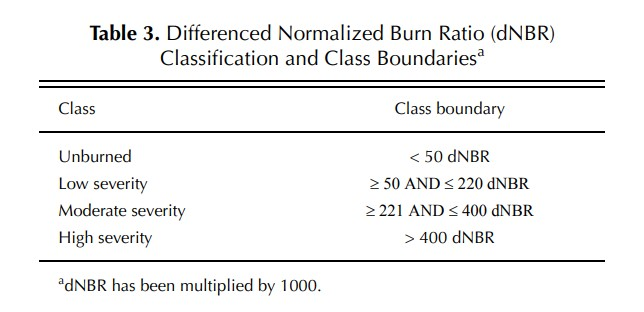
1. Low severity = 0
2. Moderate severity = 1
3. High severity = 2

In [62]:
sentinel_df["class_by_mean"] = get_class(sentinel_df["mean_dnbr"])
sentinel_df["class_by_median"] = get_class(sentinel_df["median_dnbr"])

### 4.2.5 Countplot of Sentinel-2 Burn Severity Class by Mean dNBR


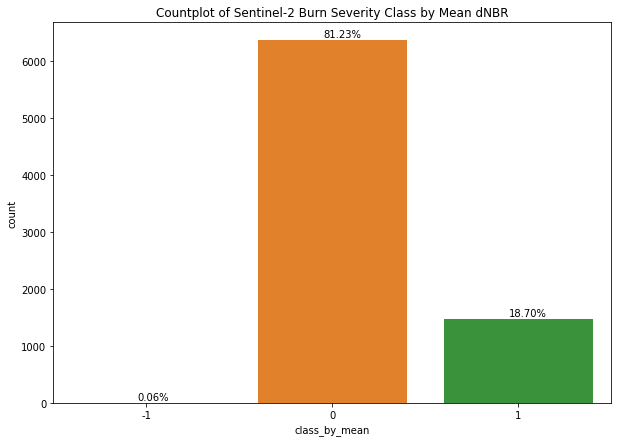

In [63]:
plt.figure(figsize=(10,7))
plt.title("Countplot of Sentinel-2 Burn Severity Class by Mean dNBR")
ax = sns.countplot(x='class_by_mean', data=sentinel_df)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(sentinel_df)*100), (p.get_x()+0.35, p.get_height()+50))
plt.show()

### 4.2.6 Countplot of Sentinel-2 Burn Severity Class by Median dNBR


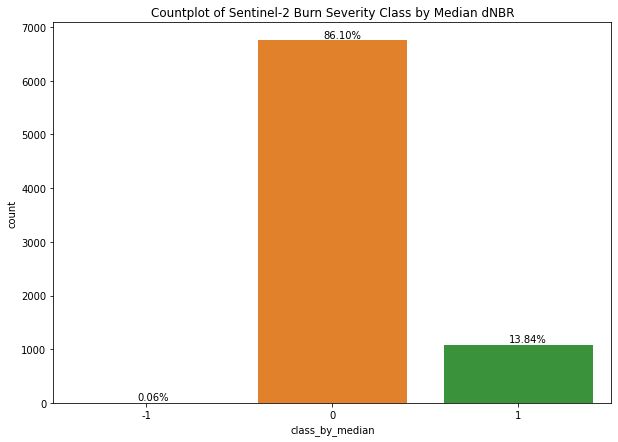

In [64]:
plt.figure(figsize=(10,7))
plt.title("Countplot of Sentinel-2 Burn Severity Class by Median dNBR")
ax = sns.countplot(x='class_by_median', data=sentinel_df)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(sentinel_df)*100), (p.get_x()+0.35, p.get_height()+50))
plt.show()

## 4.2.7 Convert GeoTIFF File to JPEG File
The conversion involve 2 steps which convert the GeoTIFF file into array of bands (fill with pixels) before being stacked and convert it into JPEG file using **opencv**.


In [65]:
image_condition = []
file_paths_jpeg = []

ext = ".jpeg"

for folder in sentinel_df['folder_paths_geotiff']:
    file_path = SENTINEL_2_JPEG_FOLDER_PATH + "\\" + folder.split('\\')[-1] + ext
#     print("\\"+"\\".join(file_path.split("\\")[1:]))
    file_paths_jpeg.append("\\"+"\\".join(file_path.split("\\")[1:]))
    print(file_path)
    if not os.path.exists(file_path):
        try:
            sentinel_postfire_img_band = get_img_as_array(folder, SENTINEL_POSTFIRE_DICT)
            result = convert_to_jpeg(
                bands = [
                    sentinel_postfire_img_band['b2'], 
                    sentinel_postfire_img_band['b3'],
                    sentinel_postfire_img_band['dnbr'],
                    
                ],
                file_path = file_path,
            )
            if result:
                image_condition.append(1)
        except:
            print(sys.exc_info()[0], "occurred.")
            image_condition.append(0)
    else:
        image_condition.append(1)
        print("{} already exist".format(file_path))

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\0.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\0
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentine

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\56.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\56
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\57.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\57
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\58.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\58
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\59.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\59
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\60.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\60
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\61.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\61
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\62.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-ge

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\113.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\113
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\114.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\114
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\115.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\115
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\116.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\116
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\117.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\117
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\118.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\118
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\119.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\169.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\169
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\170.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\170
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\171.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\171
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\172.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\172
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\173.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\173
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\174.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\174
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\175.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\224.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\224
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\225.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\225
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\226.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\226
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\227.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\227
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\228.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\228
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\229.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\229
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\230.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\279.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\279
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\280.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\280
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\281.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\281
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\282.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\282
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\283.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\283
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\284.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\284
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\285.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\335.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\335
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\336.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\336
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\337.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\337
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\338.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\338
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\339.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\339
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\340.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\340
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\341.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\391.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\391
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\392.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\392
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\393.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\393
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\394.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\394
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\395.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\395
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\396.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\396
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\397.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\447.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\447
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\448.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\448
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\449.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\449
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\450.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\450
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\451.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\451
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\452.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\452
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\453.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\503.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\503
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\504.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\504
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\505.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\505
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\506.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\506
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\507.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\507
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\508.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\508
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\509.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\559.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\559
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\560.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\560
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\561.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\561
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\562.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\562
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\563.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\563
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\564.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\564
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\565.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\615.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\615
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\616.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\616
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\617.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\617
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\618.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\618
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\619.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\619
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\620.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\620
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\621.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\671.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\671
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\672.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\672
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\673.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\673
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\674.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\674
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\675.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\675
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\676.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\676
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\677.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\727.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\727
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\728.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\728
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\729.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\729
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\730.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\730
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\731.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\731
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\732.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\732
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\733.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\783.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\783
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\784.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\784
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\785.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\785
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\786.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\786
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\787.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\787
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\788.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\788
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\789.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\839.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\839
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\840.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\840
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\841.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\841
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\842.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\842
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\843.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\843
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\844.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\844
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\845.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\895.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\895
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\896.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\896
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\897.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\897
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\898.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\898
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\899.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\899
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\900.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\900
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\901.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\951.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\951
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\952.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\952
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\953.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\953
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\954.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\954
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\955.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\955
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\956.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\956
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\957.jpeg
\wildfire-sumatera-dataset\wildfir

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1007.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1007
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1008.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1008
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1009.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1009
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1010.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1010
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1011.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1011
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1012.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1012
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1013.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1062.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1062
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1063.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1063
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1064.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1064
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1065.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1065
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1066.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1066
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1067.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1067
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1068.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1118.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1118
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1119.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1119
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1120.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1120
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1121.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1121
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1122.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1122
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1123.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1123
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1124.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1173.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1173
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1174.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1174
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1175.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1175
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1176.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1176
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1177.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1177
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1178.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1178
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1179.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1228.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1228
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1229.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1229
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1230.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1230
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1231.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1231
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1232.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1232
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1233.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1233
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1234.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1283.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1283
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1284.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1284
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1285.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1285
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1286.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1286
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1287.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1287
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1288.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1288
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1289.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1338.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1338
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1339.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1339
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1340.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1340
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1341.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1341
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1342.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1342
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1343.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1343
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1344.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1394.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1394
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1395.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1395
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1396.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1396
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1397.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1397
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1398.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1398
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1399.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1399
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1400.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1450.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1450
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1451.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1451
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1452.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1452
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1453.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1453
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1454.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1454
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1455.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1455
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1456.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1506.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1506
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1507.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1507
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1508.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1508
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1509.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1509
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1510.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1510
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1511.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1511
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1512.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1561.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1561
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1562.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1562
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1563.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1563
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1564.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1564
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1565.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1565
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1566.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1566
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1567.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1616.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1616
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1617.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1617
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1618.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1618
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1619.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1619
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1620.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1620
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1621.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1621
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1622.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1672.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1672
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1673.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1673
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1674.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1674
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1675.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1675
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1676.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1676
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1677.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1677
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1678.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1729.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1729
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1730.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1730
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1731.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1731
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1732.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1732
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1733.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1733
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1734.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1734
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1735.jpeg
\wildfire-sumatera-da

\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1783
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1784.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1784
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1785.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1785
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1786.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1786
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1787.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1787
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1788.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1788
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1789.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1789
D:\wildfire-suma

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1839.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1839
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1840.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1840
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1841.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1841
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1842.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1842
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1843.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1843
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1844.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1844
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1845.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1894.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1894
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1895.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1895
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1896.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1896
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1897.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1897
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1898.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1898
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1899.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1899
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1900.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1950.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1950
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1951.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1951
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1952.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1952
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1953.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1953
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1954.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1954
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1955.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\1955
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\1956.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2005.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2005
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2006.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2006
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2007.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2007
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2008.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2008
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2009.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2009
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2010.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2010
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2011.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2061.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2061
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2062.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2062
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2063.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2063
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2064.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2064
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2065.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2065
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2066.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2066
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2067.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2117.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2117
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2118.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2118
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2119.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2119
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2120.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2120
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2121.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2121
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2122.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2122
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2123.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2173.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2173
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2174.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2174
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2175.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2175
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2176.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2176
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2177.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2177
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2178.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2178
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2179.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2228.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2228
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2229.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2229
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2230.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2230
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2231.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2231
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2232.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2232
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2233.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2233
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2234.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2283.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2283
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2284.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2284
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2285.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2285
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2286.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2286
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2287.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2287
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2288.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2288
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2289.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2339.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2339
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2340.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2340
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2341.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2341
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2342.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2342
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2343.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2343
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2344.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2344
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2345.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2395.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2395
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2396.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2396
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2397.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2397
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2398.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2398
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2399.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2399
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2400.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2400
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2401.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2451.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2451
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2452.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2452
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2453.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2453
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2454.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2454
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2455.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2455
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2456.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2456
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2457.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2508.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2508
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2509.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2509
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2510.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2510
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2511.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2511
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2512.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2512
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2513.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2513
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2514.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2564.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2564
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2565.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2565
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2566.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2566
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2567.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2567
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2568.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2568
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2569.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2569
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2570.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2620.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2620
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2621.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2621
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2622.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2622
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2623.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2623
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2624.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2624
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2625.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2625
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2626.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2675.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2675
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2676.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2676
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2677.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2677
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2678.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2678
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2679.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2679
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2680.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2680
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2681.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2731.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2731
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2732.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2732
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2733.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2733
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2734.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2734
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2735.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2735
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2736.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2736
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2737.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2787.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2787
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2788.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2788
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2789.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2789
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2790.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2790
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2791.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2791
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2792.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2792
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2793.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2842.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2842
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2843.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2843
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2844.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2844
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2845.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2845
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2846.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2846
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2847.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2847
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2848.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2897.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2897
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2898.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2898
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2899.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2899
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2900.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2900
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2901.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2901
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2902.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2902
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2903.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2953.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2953
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2954.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2954
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2955.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2955
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2956.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2956
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2957.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2957
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2958.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\2958
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\2959.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3008.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3008
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3009.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3009
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3010.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3010
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3011.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3011
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3012.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3012
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3013.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3013
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3014.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3063.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3063
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3064.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3064
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3065.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3065
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3066.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3066
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3067.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3067
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3068.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3068
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3069.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3118.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3118
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3119.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3119
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3120.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3120
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3121.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3121
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3122.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3122
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3123.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3123
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3124.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3173.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3173
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3174.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3174
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3175.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3175
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3176.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3176
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3177.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3177
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3178.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3178
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3179.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3229.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3229
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3230.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3230
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3231.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3231
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3232.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3232
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3233.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3233
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3234.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3234
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3235.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3284.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3284
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3285.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3285
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3286.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3286
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3287.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3287
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3288.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3288
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3289.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3289
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3290.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3340.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3340
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3341.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3341
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3342.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3342
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3343.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3343
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3344.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3344
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3345.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3345
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3346.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3395.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3395
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3396.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3396
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3397.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3397
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3398.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3398
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3399.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3399
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3400.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3400
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3401.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3451.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3451
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3452.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3452
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3453.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3453
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3454.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3454
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3455.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3455
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3456.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3456
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3457.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3506.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3506
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3507.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3507
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3508.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3508
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3509.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3509
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3510.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3510
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3511.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3511
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3512.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3562.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3562
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3563.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3563
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3564.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3564
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3565.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3565
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3566.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3566
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3567.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3567
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3568.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3617.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3617
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3618.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3618
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3619.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3619
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3620.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3620
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3621.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3621
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3622.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3622
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3623.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3673.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3673
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3674.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3674
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3675.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3675
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3676.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3676
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3677.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3677
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3678.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3678
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3679.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3729.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3729
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3730.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3730
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3731.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3731
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3732.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3732
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3733.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3733
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3734.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3734
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3735.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3785.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3785
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3786.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3786
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3787.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3787
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3788.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3788
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3789.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3789
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3790.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3790
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3791.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3840.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3840
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3841.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3841
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3842.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3842
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3843.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3843
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3844.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3844
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3845.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3845
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3846.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3895.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3895
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3896.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3896
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3897.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3897
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3898.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3898
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3899.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3899
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3900.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3900
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3901.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3951.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3951
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3952.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3952
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3953.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3953
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3954.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3954
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3955.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3955
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3956.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\3956
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\3957.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4007.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4007
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4008.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4008
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4009.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4009
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4010.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4010
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4011.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4011
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4012.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4012
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4013.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4063.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4063
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4064.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4064
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4065.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4065
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4066.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4066
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4067.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4067
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4068.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4068
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4069.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4118.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4118
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4119.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4119
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4120.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4120
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4121.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4121
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4122.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4122
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4123.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4123
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4124.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4174.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4174
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4175.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4175
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4176.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4176
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4177.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4177
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4178.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4178
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4179.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4179
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4180.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4230.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4230
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4231.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4231
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4232.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4232
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4233.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4233
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4234.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4234
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4235.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4235
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4236.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4286.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4286
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4287.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4287
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4288.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4288
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4289.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4289
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4290.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4290
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4291.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4291
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4292.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4341.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4341
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4342.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4342
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4343.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4343
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4344.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4344
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4345.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4345
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4346.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4346
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4347.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4397.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4397
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4398.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4398
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4399.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4399
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4400.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4400
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4401.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4401
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4402.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4402
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4403.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4453.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4453
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4454.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4454
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4455.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4455
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4456.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4456
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4457.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4457
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4458.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4458
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4459.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4509.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4509
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4510.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4510
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4511.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4511
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4512.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4512
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4513.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4513
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4514.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4514
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4515.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4565.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4565
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4566.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4566
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4567.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4567
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4568.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4568
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4569.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4569
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4570.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4570
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4571.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4620.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4620
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4621.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4621
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4622.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4622
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4623.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4623
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4624.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4624
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4625.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4625
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4626.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4676.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4676
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4677.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4677
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4678.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4678
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4679.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4679
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4680.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4680
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4681.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4681
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4682.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4732.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4732
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4733.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4733
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4734.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4734
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4735.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4735
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4736.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4736
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4737.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4737
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4738.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4788.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4788
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4789.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4789
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4790.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4790
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4791.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4791
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4792.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4792
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4793.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4793
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4794.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4844.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4844
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4845.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4845
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4846.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4846
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4847.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4847
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4848.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4848
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4849.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4849
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4850.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4900.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4900
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4901.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4901
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4902.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4902
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4903.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4903
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4904.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4904
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4905.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4905
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4906.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4956.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4956
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4957.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4957
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4958.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4958
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4959.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4959
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4960.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4960
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4961.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\4961
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\4962.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5012.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5012
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5013.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5013
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5014.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5014
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5015.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5015
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5016.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5016
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5017.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5017
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5018.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5068.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5068
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5069.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5069
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5070.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5070
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5071.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5071
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5072.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5072
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5073.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5073
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5074.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5124.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5124
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5125.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5125
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5126.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5126
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5127.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5127
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5128.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5128
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5129.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5129
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5130.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5180.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5180
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5181.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5181
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5182.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5182
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5183.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5183
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5184.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5184
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5185.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5185
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5186.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5236.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5236
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5237.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5237
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5238.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5238
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5239.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5239
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5240.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5240
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5241.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5241
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5242.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5292.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5292
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5293.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5293
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5294.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5294
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5295.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5295
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5296.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5296
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5297.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5297
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5298.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5348.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5348
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5349.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5349
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5350.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5350
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5351.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5351
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5352.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5352
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5353.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5353
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5354.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5404.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5404
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5405.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5405
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5406.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5406
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5407.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5407
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5408.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5408
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5409.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5409
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5410.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5460.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5460
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5461.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5461
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5462.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5462
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5463.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5463
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5464.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5464
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5465.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5465
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5466.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5516.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5516
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5517.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5517
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5518.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5518
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5519.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5519
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5520.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5520
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5521.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5521
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5522.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5572.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5572
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5573.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5573
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5574.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5574
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5575.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5575
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5576.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5576
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5577.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5577
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5578.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5627.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5627
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5628.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5628
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5629.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5629
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5630.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5630
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5631.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5631
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5632.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5632
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5633.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5683.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5683
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5684.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5684
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5685.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5685
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5686.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5686
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5687.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5687
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5688.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5688
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5689.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5739.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5739
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5740.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5740
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5741.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5741
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5742.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5742
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5743.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5743
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5744.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5744
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5745.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5795.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5795
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5796.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5796
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5797.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5797
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5798.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5798
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5799.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5799
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5800.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5800
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5801.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5851.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5851
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5852.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5852
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5853.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5853
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5854.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5854
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5855.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5855
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5856.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5856
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5857.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5907.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5907
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5908.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5908
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5909.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5909
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5910.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5910
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5911.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5911
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5912.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5912
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5913.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5963.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5963
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5964.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5964
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5965.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5965
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5966.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5966
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5967.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5967
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5968.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\5968
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\5969.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6019.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6019
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6020.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6020
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6021.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6021
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6022.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6022
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6023.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6023
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6024.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6024
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6025.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6075.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6075
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6076.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6076
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6077.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6077
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6078.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6078
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6079.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6079
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6080.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6080
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6081.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6130.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6130
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6131.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6131
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6132.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6132
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6133.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6133
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6134.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6134
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6135.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6135
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6136.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6186.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6186
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6187.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6187
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6188.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6188
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6189.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6189
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6190.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6190
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6191.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6191
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6192.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6242.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6242
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6243.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6243
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6244.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6244
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6245.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6245
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6246.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6246
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6247.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6247
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6248.jpeg
\wildfire-sumatera-da

\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6298
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6299.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6299
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6300.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6300
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6301.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6301
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6302.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6302
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6303.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6303
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6304.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6304
D:\wildfire-suma

\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6353
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6354.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6354
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6355.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6355
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6356.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6356
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6357.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6357
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6358.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6358
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6359.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6359
D:\wildfire-suma

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6408.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6408
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6409.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6409
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6410.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6410
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6411.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6411
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6412.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6412
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6413.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6413
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6414.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6464.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6464
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6465.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6465
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6466.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6466
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6467.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6467
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6468.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6468
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6469.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6469
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6470.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6520.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6520
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6521.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6521
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6522.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6522
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6523.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6523
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6524.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6524
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6525.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6525
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6526.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6575.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6575
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6576.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6576
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6577.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6577
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6578.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6578
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6579.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6579
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6580.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6580
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6581.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6631.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6631
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6632.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6632
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6633.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6633
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6634.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6634
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6635.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6635
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6636.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6636
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6637.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6687.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6687
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6688.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6688
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6689.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6689
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6690.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6690
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6691.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6691
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6692.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6692
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6693.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6743.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6743
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6744.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6744
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6745.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6745
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6746.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6746
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6747.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6747
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6748.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6748
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6749.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6799.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6799
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6800.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6800
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6801.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6801
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6802.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6802
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6803.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6803
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6804.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6804
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6805.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6855.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6855
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6856.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6856
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6857.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6857
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6858.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6858
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6859.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6859
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6860.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6860
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6861.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6911.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6911
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6912.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6912
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6913.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6913
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6914.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6914
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6915.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6915
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6916.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6916
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6917.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6966.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6966
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6967.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6967
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6968.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6968
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6969.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6969
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6970.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6970
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6971.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\6971
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\6972.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7022.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7022
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7023.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7023
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7024.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7024
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7025.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7025
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7026.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7026
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7027.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7027
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7028.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7078.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7078
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7079.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7079
<class 'cv2.error'> occurred.
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7080.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7080
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7081.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7081
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7082.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7082
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7083.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7083
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7133.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7133
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7134.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7134
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7135.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7135
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7136.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7136
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7137.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7137
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7138.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7138
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7139.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7189.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7189
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7190.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7190
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7191.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7191
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7192.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7192
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7193.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7193
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7194.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7194
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7195.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7245.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7245
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7246.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7246
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7247.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7247
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7248.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7248
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7249.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7249
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7250.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7250
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7251.jpeg
\wildfire-sumatera-da

\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7300
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7301.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7301
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7302.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7302
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7303.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7303
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7304.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7304
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7305.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7305
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7306.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7306
D:\wildfire-suma

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7356.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7356
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7357.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7357
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7358.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7358
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7359.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7359
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7360.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7360
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7361.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7361
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7362.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7412.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7412
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7413.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7413
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7414.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7414
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7415.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7415
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7416.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7416
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7417.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7417
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7418.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7468.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7468
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7469.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7469
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7470.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7470
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7471.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7471
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7472.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7472
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7473.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7473
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7474.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7523.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7523
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7524.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7524
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7525.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7525
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7526.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7526
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7527.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7527
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7528.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7528
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7529.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7579.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7579
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7580.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7580
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7581.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7581
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7582.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7582
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7583.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7583
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7584.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7584
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7585.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7635.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7635
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7636.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7636
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7637.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7637
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7638.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7638
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7639.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7639
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7640.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7640
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7641.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7691.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7691
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7692.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7692
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7693.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7693
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7694.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7694
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7695.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7695
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7696.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7696
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7697.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7748.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7748
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7749.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7749
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7750.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7750
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7751.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7751
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7752.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7752
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7753.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7753
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7754.jpeg
\wildfire-sumatera-da

D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7805.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7805
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7806.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7806
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7807.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7807
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7808.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7808
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7809.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7809
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7810.jpeg
\wildfire-sumatera-dataset\wildfire-sumatera-geotiff\sentinel-2\postfire\7810
D:\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2\7811.jpeg
\wildfire-sumatera-da

In [70]:
sentinel_df["image_condition"] = image_condition
sentinel_df["file_paths_jpeg"] = file_paths_jpeg

## 4.2.8 Save Sentinel Dataframe as CSV

In [73]:
sentinel_df.to_csv(WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_sentinel_2_new.csv", index=False)
sentinel_df = pd.read_csv(WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_sentinel_2_new.csv")
display(sentinel_df.head())

folder_paths_geotiff  mean_dnbr  median_dnbr  \
0  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124348     0.098779   
1  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124229     0.098487   
2  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.123137     0.096676   
3  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.141992     0.104607   
4  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124485     0.098878   

   class_by_mean  class_by_median  image_condition  \
0              0                0                1   
1              0                0                1   
2              0                0                1   
3              0                0                1   
4              0                0                1   

                                     file_paths_jpeg  
0  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
1  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
2  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
3  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
4  \wildfire-sumatera-dataset\wildfire-sumatera-j...

# Creating Dataset for Deep Learning Studio

## Reorganize .jpeg file
.jpeg files inside **\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8** and **\wildfire-sumatera-dataset\wildfire-sumatera-jpeg\sentinel-2** will be reorganize into folder of labels indicate its severety burn classes.

In [9]:
# landsat-8 .jpeg files
landsat_df = pd.read_csv(dp.WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_landsat_8_new.csv")
display(landsat_df.head())

# sentinel-2 .jpeg files
sentinel_df = pd.read_csv(dp.WILDFIRE_SUMATERA_DATASET_FOLDER_PATH+"\\metadata_sentinel_2_new.csv")
display(sentinel_df.head())

folder_paths_geotiff  mean_dnbr  median_dnbr  \
0  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.118657     0.092437   
1  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.118892     0.092641   
2  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124600     0.095925   
3  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.099432     0.074912   
4  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.118605     0.092377   

   class_by_mean  class_by_median  image_condition  \
0              0                0                1   
1              0                0                1   
2              0                0                1   
3              0                0                1   
4              0                0                1   

                                     file_paths_jpeg  
0  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
1  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
2  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
3  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
4  \wildfire-sumatera-dataset\wildfire-sumatera-j...

folder_paths_geotiff  mean_dnbr  median_dnbr  \
0  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124348     0.098779   
1  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124229     0.098487   
2  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.123137     0.096676   
3  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.141992     0.104607   
4  \wildfire-sumatera-dataset\wildfire-sumatera-g...   0.124485     0.098878   

   class_by_mean  class_by_median  image_condition  \
0              0                0                1   
1              0                0                1   
2              0                0                1   
3              0                0                1   
4              0                0                1   

                                     file_paths_jpeg  
0  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
1  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
2  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
3  \wildfire-sumatera-dataset\wildfire-sumatera-j...  
4  \wildfire-sumatera-dataset\wildfire-sumatera-j...

## Move data for Deep Learning Studio

In [10]:
if os.getcwd() != dp.WILDFIRE_SUMATERA_DATASET_FOLDER_PATH:
    os.chdir(dp.WILDFIRE_SUMATERA_DATASET_FOLDER_PATH)
    print(os.getcwd())

if "wildfire-sumatera-dst" not in os.listdir():
    os.mkdir("wildfire-sumatera-dst")

if os.path.exists("./wildfire-sumatera-dst"):
    os.chdir("wildfire-sumatera-dst")
    if "wildfire-sumatera-sentinel-2-dst" not in os.listdir():
        os.mkdir("wildfire-sumatera-sentinel-2-dst")
    if "wildfire-sumatera-landsat-8-dst" not in os.listdir():
        os.mkdir("wildfire-sumatera-landsat-8-dst")

F:\wildfire-sumatera-dataset


In [174]:
import shutil
# wildfire-sumatera-sentinel-2-dst
if os.getcwd().split("\\")[-1] != "wildfire-sumatera-sentinel-2-dst":
    os.chdir("..\wildfire-sumatera-dst\\wildfire-sumatera-sentinel-2-dst")
    print(os.getcwd())
    

for class_name in sentinel_df["class_by_mean"].unique():
    if str(class_name) not in os.listdir():
        os.mkdir(str(class_name))


# copy jpeg files to wildfire-sumatera-sentinel-2-dst folder
def copy_files(df, target_folder):
    for index, row in df.iterrows(): 
        original_path = row['file_paths_jpeg']
        file_name = os.path.basename(original_path)
        target_path = target_folder + f"\\{file_name}"
        if os.path.exists(original_path):
            if os.path.exists(target_path) == 0:
                print(f"copying from {row['file_paths_jpeg']} to {target_path}")
                shutil.copyfile(row['file_paths_jpeg'], target_folder+f"\\{file_name}")
            else:
                print(f"{target_path} already exists")
        else:
            print(f"{original_path} doesn't exists")
            
copy_files(
    df = sentinel_df.loc[sentinel_df["class_by_mean"]== 0], 
    target_folder = "\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-sentinel-2-dst\\0",
)
copy_files(
    df = sentinel_df.loc[sentinel_df["class_by_mean"] == 1], 
    target_folder = "\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-sentinel-2-dst\\1",
)
copy_files(
    df = sentinel_df.loc[sentinel_df["class_by_mean"] == 2], 
    target_folder = "\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-sentinel-2-dst\\2",
)

True
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\0.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\8.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumat

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\136.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\137.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\138.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\139.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\140.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\141.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\142.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\143.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\144.jpeg already exists
\wildfire-sumatera-dataset\w

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\254.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\255.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\256.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\257.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\258.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\259.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\260.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\261.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\262.jpeg already exists
\wildfire-sumatera-dataset\w

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\397.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\398.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\399.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\400.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\401.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\402.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\403.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\404.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\405.jpeg already exists
\wildfire-sumatera-dataset\w

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\496.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\497.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\498.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\499.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\500.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\501.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\502.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\503.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\504.jpeg already exists
\wildfire-sumatera-dataset\w

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\595.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\596.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\597.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\598.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\599.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\600.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\601.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\602.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\603.jpeg already exists
\wildfire-sumatera-dataset\w

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\684.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\685.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\686.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\687.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\688.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\689.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\690.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\691.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\692.jpeg already exists
\wildfire-sumatera-dataset\w

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\789.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\790.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\791.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\792.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\793.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\794.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\795.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\796.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\797.jpeg already exists
\wildfire-sumatera-dataset\w

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\875.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\876.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\877.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\878.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\879.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\880.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\881.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\882.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\883.jpeg already exists
\wildfire-sumatera-dataset\w

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\969.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\970.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\971.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\972.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\973.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\974.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\975.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\976.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\977.jpeg already exists
\wildfire-sumatera-dataset\w

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1066.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1067.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1068.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1069.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1070.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1071.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1072.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1073.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1074.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1158.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1159.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1160.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1161.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1162.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1163.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1164.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1165.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1166.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1243.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1244.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1245.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1246.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1247.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1248.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1249.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1250.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1251.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1323.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1324.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1325.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1326.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1327.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1328.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1329.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1330.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1331.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1401.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1402.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1403.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1404.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1405.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1406.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1407.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1408.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1409.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1502.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1503.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1504.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1505.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1506.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1507.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1508.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1509.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1510.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1582.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1583.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1584.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1585.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1586.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1587.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1588.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1589.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1590.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1670.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1671.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1672.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1673.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1674.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1675.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1676.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1677.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1678.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1762.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1763.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1764.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1765.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1766.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1767.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1768.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1769.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1770.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1849.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1850.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1851.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1852.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1853.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1854.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1855.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1856.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\1857.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2007.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2008.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2009.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2010.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2011.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2012.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2013.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2014.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2015.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2089.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2090.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2091.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2092.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2093.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2094.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2095.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2096.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2097.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2230.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2231.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2232.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2233.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2234.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2235.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2236.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2237.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2238.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2376.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2377.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2378.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2379.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2380.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2381.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2382.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2383.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2384.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2454.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2455.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2456.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2457.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2458.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2459.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2460.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2461.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2462.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2548.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2549.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2550.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2551.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2552.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2553.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2554.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2555.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2556.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2643.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2644.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2645.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2646.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2647.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2648.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2649.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2650.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2651.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2726.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2735.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2736.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2738.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2739.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2743.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2744.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2747.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2748.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2846.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2847.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2850.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2851.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2852.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2853.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2854.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2855.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\2856.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3093.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3094.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3095.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3096.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3097.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3098.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3100.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3101.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3102.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3514.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3515.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3516.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3517.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3518.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3519.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3520.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3521.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\3522.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4023.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4024.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4025.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4026.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4027.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4028.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4029.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4030.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4031.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4304.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4305.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4306.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4307.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4308.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4309.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4310.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4311.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4312.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4732.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4733.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4734.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4735.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4736.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4737.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4738.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4739.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\4740.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5150.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5153.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5154.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5155.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5157.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5159.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5160.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5161.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5162.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5641.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5642.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5643.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5644.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5645.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5646.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5647.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5648.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5657.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5924.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5925.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5926.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5927.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5928.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5929.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5930.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5931.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\5932.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6145.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6147.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6148.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6149.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6150.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6151.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6152.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6153.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6154.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6348.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6349.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6350.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6351.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6353.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6354.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6355.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6359.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6360.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6535.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6536.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6537.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6538.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6539.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6540.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6541.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6542.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6543.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6667.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6668.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6669.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6670.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6671.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6673.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6674.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6675.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6676.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6813.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6814.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6815.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6816.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6817.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6818.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6819.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6820.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6821.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6951.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6952.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6953.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6954.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6955.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6956.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6957.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6958.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\6959.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7085.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7087.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7088.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7089.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7090.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7091.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7092.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7093.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7094.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7188.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7189.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7190.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7191.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7192.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7193.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7194.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7195.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7196.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7310.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7311.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7312.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7313.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7314.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7315.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7316.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7317.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7318.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7440.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7441.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7442.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7443.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7444.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7445.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7446.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7447.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7448.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7560.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7561.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7562.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7563.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7564.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7565.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7566.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7567.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7568.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7669.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7670.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7671.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7672.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7673.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7674.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7675.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7676.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7677.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7773.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7774.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7775.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7776.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7777.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7778.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7779.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7780.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\0\7781.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2536.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2542.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2546.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2562.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2589.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2593.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2602.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2603.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2611.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2903.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2906.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2907.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2919.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2946.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2949.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2950.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2964.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\2969.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4486.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4487.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4490.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4491.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4492.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4493.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4494.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4495.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4496.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4980.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4981.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4982.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4983.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4984.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4985.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4986.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4987.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\4988.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5317.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5318.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5319.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5320.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5321.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5322.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5323.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5324.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5325.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5577.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5578.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5579.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5582.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5583.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5584.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5585.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5594.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\5597.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6057.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6059.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6062.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6063.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6064.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6065.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6066.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6067.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6069.jpeg already exists
\wildfire-sumatera-

\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6497.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6512.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6514.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6515.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6516.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6520.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6521.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6522.jpeg already exists
\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-sentinel-2-dst\1\6524.jpeg already exists
\wildfire-sumatera-

In [178]:
import shutil
# wildfire-sumatera-landsat-8-dst
if os.getcwd().split("\\")[-1] != "wildfire-sumatera-landsat-8-dst":
    os.chdir("\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-landsat-8-dst")
    print(os.getcwd())
    

for class_name in landsat_df["class_by_mean"].unique():
    if str(class_name) not in os.listdir():
        os.mkdir(str(class_name))


# copy jpeg files to wildfire-sumatera-landsat-8-dst folder
def copy_files(df, target_folder):
    for index, row in df.iterrows(): 
        original_path = row['file_paths_jpeg']
        file_name = os.path.basename(original_path)
        target_path = target_folder + f"\\{file_name}"
        if os.path.exists(original_path):
            if os.path.exists(target_path) == 0:
                print(f"copying from {row['file_paths_jpeg']} to {target_path}")
                shutil.copyfile(row['file_paths_jpeg'], target_folder+f"\\{file_name}")
            else:
                print(f"{target_path} already exists")
        else:
            print(f"{original_path} doesn't exists")
            
copy_files(
    df = landsat_df.loc[landsat_df["class_by_mean"] == 0], 
    target_folder = "\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-landsat-8-dst\\0",
)
copy_files(
    df = landsat_df.loc[landsat_df["class_by_mean"] == 1], 
    target_folder = "\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-landsat-8-dst\\1",
)

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\0.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\0.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\57.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\57.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\58.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\58.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\59.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\59.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\60.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\60.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\61.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\61.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\62.jpeg to \wildfire-sumatera-dataset\wildfire-sumat

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\109.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\109.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\110.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\110.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\111.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\111.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\112.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\112.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\113.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\113.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\114.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\166.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\166.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\167.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\167.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\168.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\168.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\169.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\169.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\170.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\170.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\171.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\223.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\223.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\224.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\224.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\225.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\225.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\226.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\226.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\227.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\227.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\228.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\280.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\280.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\281.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\281.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\282.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\282.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\283.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\283.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\284.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\284.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\285.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\340.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\340.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\341.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\341.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\342.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\342.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\343.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\343.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\344.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\344.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\345.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\397.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\397.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\398.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\398.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\399.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\399.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\400.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\400.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\401.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\401.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\402.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\455.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\455.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\456.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\456.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\457.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\457.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\458.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\458.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\459.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\459.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\460.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\507.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\507.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\508.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\508.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\509.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\509.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\510.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\510.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\511.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\511.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\512.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\564.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\564.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\565.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\565.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\566.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\566.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\567.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\567.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\568.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\568.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\569.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\625.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\625.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\626.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\626.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\627.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\627.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\628.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\628.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\629.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\629.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\630.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\682.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\682.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\683.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\683.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\684.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\684.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\685.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\685.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\686.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\686.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\687.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\733.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\733.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\734.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\734.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\735.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\735.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\736.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\736.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\737.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\737.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\738.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\791.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\791.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\792.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\792.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\793.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\793.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\794.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\794.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\795.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\795.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\796.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\849.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\849.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\850.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\850.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\851.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\851.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\852.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\852.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\853.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\853.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\854.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\905.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\905.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\906.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\906.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\907.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\907.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\908.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\908.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\909.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\909.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\910.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\956.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\956.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\957.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\957.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\958.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\958.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\959.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\959.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\960.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\960.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\961.jpeg to \wildfire-sumatera-dataset\wil

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1005.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1005.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1006.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1006.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1007.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1007.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1008.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1008.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1009.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1009.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1010.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1062.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1062.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1063.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1063.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1064.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1064.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1065.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1065.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1066.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1066.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1067.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1109.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1109.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1110.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1110.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1111.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1111.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1112.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1112.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1113.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1113.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1114.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1162.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1162.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1163.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1163.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1164.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1164.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1165.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1165.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1166.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1166.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1167.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1219.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1219.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1220.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1220.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1221.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1221.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1222.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1222.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1223.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1223.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1224.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1265.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1265.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1266.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1266.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1267.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1267.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1268.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1268.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1269.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1269.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1270.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1318.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1318.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1319.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1319.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1320.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1320.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1321.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1321.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1322.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1322.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1323.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1367.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1367.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1368.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1368.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1369.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1369.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1370.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1370.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1371.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1371.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1372.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1417.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1417.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1418.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1418.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1419.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1419.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1420.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1420.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1421.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1421.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1422.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1468.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1468.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1469.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1469.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1470.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1470.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1471.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1471.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1472.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1472.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1473.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1520.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1520.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1521.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1521.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1522.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1522.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1523.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1523.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1524.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1524.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1525.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1571.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1571.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1572.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1572.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1573.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1573.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1574.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1574.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1575.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1575.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1576.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1618.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1618.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1619.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1619.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1620.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1620.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1621.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1621.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1622.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1622.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1623.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1668.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1668.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1669.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1669.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1670.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1670.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1671.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1671.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1672.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1672.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1673.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1726.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1726.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1727.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1727.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1728.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1728.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1729.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1729.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1730.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1730.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1731.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1776.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1776.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1777.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1777.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1778.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1778.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1779.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1779.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1780.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1780.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1781.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1825.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1825.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1826.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1826.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1827.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1827.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1828.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1828.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1829.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1829.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1830.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1874.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1874.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1875.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1875.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1876.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1876.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1877.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1877.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1878.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1878.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1879.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1926.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1926.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1927.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1927.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1928.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1928.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1929.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1929.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1930.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1930.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1931.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1975.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1975.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1976.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1976.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1977.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1977.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1978.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1978.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1979.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\1979.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\1980.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2022.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2022.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2023.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2023.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2024.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2024.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2025.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2025.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2026.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2026.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2027.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2076.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2076.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2077.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2077.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2078.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2078.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2079.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2079.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2080.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2080.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2081.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2125.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2125.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2126.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2126.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2127.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2127.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2128.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2128.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2129.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2129.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2130.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2174.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2174.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2175.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2175.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2176.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2176.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2177.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2177.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2178.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2178.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2179.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2235.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2235.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2236.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2236.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2237.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2237.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2238.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2238.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2239.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2239.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2240.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2281.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2281.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2282.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2282.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2283.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2283.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2284.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2284.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2285.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2285.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2286.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2331.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2331.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2332.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2332.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2333.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2333.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2334.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2334.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2335.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2335.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2336.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2392.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2392.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2393.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2393.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2394.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2394.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2395.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2395.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2396.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2396.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2397.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2448.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2448.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2449.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2449.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2450.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2450.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2451.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2451.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2452.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2452.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2453.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2505.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2505.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2506.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2506.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2507.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2507.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2508.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2508.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2509.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2509.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2510.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2551.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2551.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2552.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2552.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2553.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2553.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2554.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2554.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2555.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2555.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2556.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2604.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2604.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2605.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2605.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2606.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2606.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2607.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2607.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2608.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2608.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2609.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2658.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2658.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2659.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2659.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2660.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2660.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2661.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2661.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2662.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2662.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2663.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2710.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2710.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2711.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2711.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2712.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2712.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2713.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2713.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2714.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2714.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2715.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2761.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2761.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2762.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2762.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2763.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2763.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2764.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2764.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2765.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2765.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2766.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2813.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2813.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2814.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2814.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2815.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2815.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2816.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2816.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2817.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2817.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2818.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2861.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2861.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2862.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2862.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2863.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2863.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2865.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2865.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2866.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2866.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2867.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2921.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2921.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2922.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2922.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2923.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2923.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2924.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2924.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2925.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2925.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2926.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2981.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2981.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2982.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2982.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2983.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2983.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2984.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2984.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2985.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\2985.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\2986.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3042.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3042.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3043.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3043.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3044.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3044.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3045.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3045.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3046.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3046.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3047.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3143.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3143.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3144.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3144.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3145.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3145.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3146.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3146.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3147.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3147.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3148.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3198.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3198.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3199.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3199.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3200.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3200.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3201.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3201.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3202.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3202.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3203.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3249.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3249.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3250.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3250.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3251.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3251.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3252.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3252.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3253.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3253.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3254.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3302.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3302.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3303.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3303.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3304.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3304.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3305.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3305.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3306.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3306.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3308.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3379.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3379.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3380.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3380.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3381.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3381.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3382.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3382.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3383.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3383.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3384.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3454.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3454.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3455.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3455.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3456.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3456.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3457.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3457.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3458.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3458.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3459.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3513.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3513.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3514.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3514.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3515.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3515.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3516.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3516.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3517.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3517.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3518.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3582.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3582.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3583.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3583.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3585.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3585.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3586.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3586.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3587.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3587.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3591.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3665.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3665.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3666.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3666.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3667.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3667.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3668.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3668.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3669.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3669.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3670.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3725.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3725.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3726.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3726.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3727.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3727.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3728.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3728.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3729.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3729.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3730.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3778.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3778.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3779.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3779.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3780.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3780.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3781.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3781.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3782.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3782.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3783.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3826.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3826.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3827.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3827.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3828.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3828.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3829.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3829.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3830.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3830.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3831.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3878.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3878.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3879.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3879.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3880.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3880.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3883.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3883.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3885.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3885.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3886.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3954.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3954.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3955.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3955.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3956.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3956.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3957.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3957.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3958.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\3958.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3959.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4013.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4013.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4014.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4014.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4015.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4015.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4016.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4016.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4017.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4017.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4018.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4060.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4060.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4061.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4061.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4062.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4062.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4063.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4063.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4064.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4064.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4065.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4123.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4123.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4124.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4124.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4125.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4125.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4126.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4126.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4127.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4127.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4128.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4175.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4175.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4176.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4176.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4177.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4177.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4178.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4178.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4179.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4179.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4183.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4258.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4258.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4259.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4259.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4260.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4260.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4261.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4261.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4266.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4266.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4267.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4329.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4329.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4330.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4330.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4331.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4331.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4332.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4332.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4333.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4333.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4335.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4456.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4456.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4457.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4457.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4458.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4458.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4459.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4459.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4470.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4470.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4474.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4571.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4571.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4573.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4573.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4575.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4575.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4576.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4576.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4577.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4577.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4578.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4652.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4652.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4653.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4653.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4654.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4654.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4655.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4655.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4656.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4656.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4657.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4704.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4704.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4705.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4705.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4706.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4706.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4707.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4707.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4708.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4708.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4709.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4753.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4753.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4754.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4754.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4755.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4755.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4756.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4756.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4757.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4757.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4758.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4815.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4815.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4816.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4816.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4817.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4817.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4818.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4818.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4819.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4819.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4820.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4958.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4958.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4959.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4959.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4960.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4960.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4969.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4969.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4970.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\4970.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4971.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5035.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5035.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5036.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5036.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5037.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5037.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5038.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5038.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5039.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5039.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5040.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5118.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5118.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5124.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5124.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5125.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5125.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5129.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5129.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5135.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5135.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5139.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5206.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5206.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5207.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5207.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5208.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5208.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5209.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5209.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5210.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5210.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5212.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5379.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5379.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5394.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5394.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5395.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5395.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5396.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5396.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5398.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5398.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5399.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5505.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5505.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5506.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5506.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5507.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5507.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5508.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5508.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5509.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5509.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5512.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5589.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5589.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5590.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5590.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5591.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5591.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5592.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5592.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5593.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5593.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5595.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5653.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5653.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5657.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5657.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5659.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5659.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5660.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5660.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5661.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5661.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5662.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5724.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5724.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5725.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5725.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5726.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5726.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5727.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5727.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5728.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5728.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5729.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5806.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5806.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5807.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5807.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5808.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5808.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5809.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5809.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5810.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5810.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5811.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5902.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5902.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5903.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5903.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5904.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5904.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5905.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5905.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5906.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5906.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5907.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5952.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5952.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5953.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5953.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5956.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5956.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5958.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5958.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5959.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\5959.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5960.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6014.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6014.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6015.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6015.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6016.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6016.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6017.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6017.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6018.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6018.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6019.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6076.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6076.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6077.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6077.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6078.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6078.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6080.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6080.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6081.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6081.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6082.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6133.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6133.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6134.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6134.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6138.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6138.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6142.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6142.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6143.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6143.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6145.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6226.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6226.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6227.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6227.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6228.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6228.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6229.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6229.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6230.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6230.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6231.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6280.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6280.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6281.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6281.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6282.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6282.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6283.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6283.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6284.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6284.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6285.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6331.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6331.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6332.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6332.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6333.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6333.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6334.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6334.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6335.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6335.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6336.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6392.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6392.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6393.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6393.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6394.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6394.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6395.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6395.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6396.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6396.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6397.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6469.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6469.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6470.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6470.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6471.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6471.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6473.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6473.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6474.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6474.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6475.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6533.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6533.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6534.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6534.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6535.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6535.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6536.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6536.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6537.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6537.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6538.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6587.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6587.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6588.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6588.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6589.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6589.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6590.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6590.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6591.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6591.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6592.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6640.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6640.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6641.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6641.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6642.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6642.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6643.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6643.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6644.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6644.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6645.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6690.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6690.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6691.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6691.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6692.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6692.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6693.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6693.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6694.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6694.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6695.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6745.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6745.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6746.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6746.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6747.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6747.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6748.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6748.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6749.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6749.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6750.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6797.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6797.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6798.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6798.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6799.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6799.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6800.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6800.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6801.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6801.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6802.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6848.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6848.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6849.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6849.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6850.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6850.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6851.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6851.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6852.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6852.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6853.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6895.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6895.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6896.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6896.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6897.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6897.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6898.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6898.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6899.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6899.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6900.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6946.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6946.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6947.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6947.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6948.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6948.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6949.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6949.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6950.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6950.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6951.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6998.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6998.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6999.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\6999.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7000.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7000.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7001.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7001.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7002.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7002.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7003.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7048.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7048.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7049.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7049.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7050.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7050.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7051.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7051.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7052.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7052.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7053.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7098.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7098.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7099.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7099.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7100.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7100.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7101.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7101.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7102.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7102.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7103.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7149.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7149.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7150.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7150.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7151.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7151.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7152.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7152.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7153.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7153.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7154.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7200.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7200.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7201.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7201.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7202.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7202.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7203.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7203.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7204.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7204.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7205.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7251.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7251.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7252.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7252.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7253.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7253.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7254.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7254.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7255.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7255.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7256.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7307.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7307.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7308.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7308.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7309.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7309.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7310.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7310.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7311.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7311.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7312.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7357.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7357.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7358.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7358.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7359.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7359.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7360.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7360.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7361.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7361.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7362.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7405.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7405.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7406.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7406.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7407.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7407.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7408.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7408.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7409.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7409.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7410.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7454.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7454.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7455.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7455.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7456.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7456.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7457.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7457.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7458.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7458.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7459.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7502.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7502.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7503.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7503.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7504.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7504.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7505.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7505.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7506.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7506.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7507.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7557.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7557.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7558.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7558.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7559.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7559.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7560.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7560.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7561.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7561.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7562.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7610.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7610.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7611.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7611.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7612.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7612.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7613.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7613.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7614.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7614.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7615.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7663.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7663.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7664.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7664.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7665.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7665.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7666.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7666.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7667.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7667.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7668.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7715.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7715.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7716.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7716.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7717.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7717.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7718.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7718.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7719.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7719.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7720.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7766.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7766.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7767.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7767.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7768.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7768.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7769.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7769.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7770.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7770.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7771.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7813.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7813.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7814.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7814.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7815.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7815.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7816.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7816.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7817.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\0\7817.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7818.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3341.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3341.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3342.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3342.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3345.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3345.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3346.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3346.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3347.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3347.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3348.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3611.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3611.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3612.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3612.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3621.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3621.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3622.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3622.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3623.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\3623.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\3626.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4082.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4082.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4089.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4089.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4096.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4096.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4118.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4118.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4135.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4135.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4136.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4350.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4350.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4354.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4354.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4355.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4355.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4356.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4356.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4357.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4357.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4358.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4449.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4449.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4450.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4450.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4451.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4451.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4452.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4452.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4453.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4453.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4454.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4533.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4533.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4534.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4534.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4535.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4535.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4536.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4536.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4537.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4537.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4541.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4787.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4787.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4788.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4788.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4789.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4789.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4790.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4790.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4792.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4792.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4793.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4899.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4899.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4900.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4900.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4901.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4901.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4916.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4916.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4920.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4920.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4921.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4988.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4988.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4989.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4989.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4990.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4990.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\4999.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\4999.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5000.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5000.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5002.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5133.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5133.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5134.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5134.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5136.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5136.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5137.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5137.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5138.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5138.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5143.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5267.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5267.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5268.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5268.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5269.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5269.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5272.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5272.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5273.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5273.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5274.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5343.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5343.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5344.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5344.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5345.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5345.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5346.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5346.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5347.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5347.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5348.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5430.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5430.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5431.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5431.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5437.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5437.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5438.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5438.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5439.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5439.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5440.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5531.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5531.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5532.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5532.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5533.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5533.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5535.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5535.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5539.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5539.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5542.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5739.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5739.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5740.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5740.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5741.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5741.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5742.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5742.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5743.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5743.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5745.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5857.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5857.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5858.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5858.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5859.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5859.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5860.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5860.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5861.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\5861.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\5862.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6139.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6139.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6140.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6140.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6141.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6141.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6144.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6144.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6146.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6146.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6165.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6356.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6356.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6357.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6357.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6358.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6358.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6361.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6361.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6363.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6363.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6369.jpeg to \wildfire-sumatera-

copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6596.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6596.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6599.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6599.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\6718.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\6718.jpeg
copying from \wildfire-sumatera-dataset\wildfire-sumatera-jpeg\landsat-8\7147.jpeg to \wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst\1\7147.jpeg


## Create metadata for Deep Learning Studio

In [32]:
import shutil
# wildfire-sumatera-sentinel-2-dst
if os.getcwd().split("\\")[-1] != "wildfire-sumatera-sentinel-2-dst":
    os.chdir("F:\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-sentinel-2-dst")
    print(os.getcwd())
    

if not os.path.exists("wildfire-sumatera-metadata.csv"):
    dictionary = {}
    dictionary["image"] = []
    dictionary["class"] = []
    
    for folder in os.listdir():
        folder_path = "\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-sentinel-2-dst\\" + folder 
        os.chdir(folder_path)
        for file in os.listdir():
            dictionary["image"].append(folder_path + "\\" + file)
            dictionary["class"].append(int(folder))
    
    
    sentinel_dst_df = pd.DataFrame(dictionary) 
    sentinel_dst_df["image"] = sentinel_dst_df["image"].apply(lambda x: x.replace("\\wildfire-sumatera-dataset\\wildfire-sumatera-dst", "")) 
    display(sentinel_dst_df)
    sentinel_dst_df = sentinel_dst_df.sample(frac = 1)  
    # print the shuffled DataFrame
    display("\nShuffled DataFrame:")
    display(sentinel_dst_df)
    sentinel_dst_df.to_csv("\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-sentinel-2-dst\\wildfire-sumatera-metadata.csv", index=False)

image  class
0        \wildfire-sumatera-sentinel-2-dst\0\0.jpeg      0
1        \wildfire-sumatera-sentinel-2-dst\0\1.jpeg      0
2        \wildfire-sumatera-sentinel-2-dst\0\2.jpeg      0
3        \wildfire-sumatera-sentinel-2-dst\0\3.jpeg      0
4        \wildfire-sumatera-sentinel-2-dst\0\4.jpeg      0
...                                             ...    ...
7825  \wildfire-sumatera-sentinel-2-dst\1\7750.jpeg      1
7826  \wildfire-sumatera-sentinel-2-dst\1\7751.jpeg      1
7827  \wildfire-sumatera-sentinel-2-dst\1\7752.jpeg      1
7828  \wildfire-sumatera-sentinel-2-dst\1\7753.jpeg      1
7829  \wildfire-sumatera-sentinel-2-dst\1\7754.jpeg      1

[7830 rows x 2 columns]

'\nShuffled DataFrame:'

image  class
1194  \wildfire-sumatera-sentinel-2-dst\0\1197.jpeg      0
3605  \wildfire-sumatera-sentinel-2-dst\0\3886.jpeg      0
677    \wildfire-sumatera-sentinel-2-dst\0\679.jpeg      0
264    \wildfire-sumatera-sentinel-2-dst\0\266.jpeg      0
3982  \wildfire-sumatera-sentinel-2-dst\0\4376.jpeg      0
...                                             ...    ...
6340  \wildfire-sumatera-sentinel-2-dst\0\7815.jpeg      0
964    \wildfire-sumatera-sentinel-2-dst\0\966.jpeg      0
7508  \wildfire-sumatera-sentinel-2-dst\1\5795.jpeg      1
5788  \wildfire-sumatera-sentinel-2-dst\0\7237.jpeg      0
3597  \wildfire-sumatera-sentinel-2-dst\0\3874.jpeg      0

[7830 rows x 2 columns]

In [33]:
import shutil
# wildfire-sumatera-landsat-8-dst
if os.getcwd().split("\\")[-1] != "wildfire-sumatera-landsat-8-dst":
    os.chdir("F:\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-landsat-8-dst")
    print(os.getcwd())
    

if not os.path.exists("wildfire-sumatera-metadata.csv"):
    dictionary = {}
    dictionary["image"] = []
    dictionary["class"] = []
    
    for folder in os.listdir():
        folder_path = "\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-landsat-8-dst\\" + folder 
        os.chdir(folder_path)
        for file in os.listdir():
            dictionary["image"].append(folder_path + "\\" + file)
            dictionary["class"].append(int(folder))
    
    landsat_dst_df = pd.DataFrame(dictionary)
    landsat_dst_df["image"] = landsat_dst_df["image"].apply(lambda x: x.replace("\\wildfire-sumatera-dataset\\wildfire-sumatera-dst", "")) 
    display(landsat_dst_df)
    
    landsat_dst_df = landsat_dst_df.sample(frac = 1)  
    # print the shuffled DataFrame
    display("Shuffled DataFrame:")
    display(landsat_dst_df)
    landsat_dst_df.to_csv("\\wildfire-sumatera-dataset\\wildfire-sumatera-dst\\wildfire-sumatera-landsat-8-dst\\wildfire-sumatera-metadata.csv", index=False)

F:\wildfire-sumatera-dataset\wildfire-sumatera-dst\wildfire-sumatera-landsat-8-dst


image  class
0        \wildfire-sumatera-landsat-8-dst\0\0.jpeg      0
1        \wildfire-sumatera-landsat-8-dst\0\1.jpeg      0
2        \wildfire-sumatera-landsat-8-dst\0\2.jpeg      0
3        \wildfire-sumatera-landsat-8-dst\0\3.jpeg      0
4        \wildfire-sumatera-landsat-8-dst\0\4.jpeg      0
...                                            ...    ...
7831  \wildfire-sumatera-landsat-8-dst\1\6594.jpeg      1
7832  \wildfire-sumatera-landsat-8-dst\1\6596.jpeg      1
7833  \wildfire-sumatera-landsat-8-dst\1\6599.jpeg      1
7834  \wildfire-sumatera-landsat-8-dst\1\6718.jpeg      1
7835  \wildfire-sumatera-landsat-8-dst\1\7147.jpeg      1

[7836 rows x 2 columns]

'Shuffled DataFrame:'

image  class
3190  \wildfire-sumatera-landsat-8-dst\0\3205.jpeg      0
2771  \wildfire-sumatera-landsat-8-dst\0\2773.jpeg      0
1731  \wildfire-sumatera-landsat-8-dst\0\1731.jpeg      0
6554  \wildfire-sumatera-landsat-8-dst\0\7603.jpeg      0
6772  \wildfire-sumatera-landsat-8-dst\0\7821.jpeg      0
...                                            ...    ...
1321  \wildfire-sumatera-landsat-8-dst\0\1321.jpeg      0
1691  \wildfire-sumatera-landsat-8-dst\0\1691.jpeg      0
2504  \wildfire-sumatera-landsat-8-dst\0\2506.jpeg      0
5228  \wildfire-sumatera-landsat-8-dst\0\6186.jpeg      0
6264  \wildfire-sumatera-landsat-8-dst\0\7313.jpeg      0

[7836 rows x 2 columns]